In [1]:
%load_ext autoreload
%autoreload 2

# Orthogonality of our sponge circuit components to sRNA network

The circuit is composed of a synthetic sRNA and two fluorescent proteins mRNA's, cyRFP and EGFP.

## Imports

Use Python 3.11

In [2]:
import os
import pandas as pd
import re
import logging 
import numpy as np

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.IntaRNA.bin.copomus.IntaRNA import IntaRNA
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.circuit.common.config_setup import retrieve_default_args, load_simulator_kwargs
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA, write_fasta_file
from synbio_morpher.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs
from synbio_morpher.utils.misc.string_handling import string_to_tuple_list
from synbio_morpher.utils.misc.type_handling import get_nth_elements, flatten_listlike

from subprocess import Popen, PIPE, run
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax

# jupyter nbconvert --to notebook --execute 18_orthogonality_extra_database.ipynb --output=18_orthogonality_extra_database_all.ipynb --ExecutePreprocessor.timeout=-1

# Load data

Load the sequences for EGFP and cyRFP, along with synthetic ChiX and the other sRNA's.

In [3]:
fn_tus = os.path.join('..', 'data', 'sRNA', 'EcoCyc', 'EcoCyc_TUs_DH10B.csv')
fn_srnas = os.path.join('..', 'data', 'sRNA', 'EcoCyc', 'EcoCyc_regulatory_RNAs_DH10B.csv')
fn_db = os.path.join('..', 'data', 'sRNA', 'TableS2_E_coli_with_seq.csv')
# fn_db = '../data/sRNA/TableS2_E_coli_with_seq.csv'
# fn_merged = os.path.join('..', 'data', 'sRNA', 'merged_EcoCyc_RNAInter_sRNATarBase.csv')
# fn_inter = os.path.join('..', 'data', 'sRNA', 'merged_inter.csv')
d_tus = pd.read_csv(fn_tus, index_col=0)
d_srnas = pd.read_csv(fn_srnas, index_col=0)
d_db = pd.read_csv(fn_db)
# d_merged = pd.read_csv(fn_merged, index_col=0)
# d_inter = pd.read_csv(fn_inter, index_col=0)

fn_fps = 'data/fps.fasta'
fn_muts = 'data/scott_mutations.fasta'
muts = load_seq_from_FASTA(fn_muts, as_type='dict')
fps = load_seq_from_FASTA(fn_fps, as_type='dict')

## Get new syntheses

In [4]:
sdirs = ['data/February 2024 synthesis', 'data/November 2024 synthesis']
all_synths = {}
all_overlaps = []
for sdir in sdirs:
    for f in os.listdir(sdir): 
        syn = load_seq_from_FASTA(os.path.join(sdir, f), as_type='dict')
        if any([k in all_synths for k in syn]):
            print(f'Warning: {f} has overlapping keys: {set(syn.keys()) & set(all_synths.keys())}')
            overlaps = set(syn.keys()) & set(all_synths.keys())
            for overlap in overlaps:
                all_overlaps.append(overlap)
                if not syn[overlap] == all_synths[overlap]:
                    name_new = overlap + f'_{all_overlaps.count(overlap)}'
                    print(f'Warning: {f} has different sequences for {overlap} - renaming to {name_new}')
        all_synths.update(syn)
        

## Select sRNAs from database

In [5]:
to_remove = ['e14 prophage; ', 'Qin prophage; ', 'Rac prophage; ', 
             'putative antisense regulatory RNA ', 'small regulatory RNA antitoxin ', 
             'putative antitoxin ', 'antisense regulatory RNA ', 'small antisense RNA ',
             'antitoxin ', 'small regulatory RNA ', 'small RNA ', ' small regulatory RNA']

for r in to_remove:
    d_srnas['Common-Name'] = d_srnas['Common-Name'].str.replace(r, '')
    
d_srnas['Common-Name'] = d_srnas['Common-Name'].str.replace(' ', '_')
    

In [6]:
d_tus.loc[d_tus['Common-Name'].apply(lambda x: type(x) != str), 'Common-Name'] = d_tus.loc[d_tus['Common-Name'].apply(lambda x: type(x) != str), 'Accession-1']
dupes = d_tus['Common-Name'].value_counts()[d_tus['Common-Name'].value_counts() > 1].index.to_list()
d_tus.loc[d_tus['Common-Name'].isin(dupes), 'Common-Name'] = d_tus[d_tus['Common-Name'].isin(dupes)]['Accession-1']
print('Number of duplicates:', np.sum(d_tus['Common-Name'].value_counts()[d_tus['Common-Name'].value_counts() > 1]))

Number of duplicates: 0


In [7]:
srnas = dict(zip(d_srnas['Common-Name'].to_list(), d_srnas['Sequence - DNA sequence']))
mrnas = dict(zip(d_tus['Common-Name'].to_list(), d_tus['Sequence - DNA sequence']))

### Add sRNA's from the extra database Scott sent me (Nov 2024)

In [8]:
d_db['name'] = d_db['name'].str.replace('-<i>leuZ</i>', 'leuZ').apply(lambda x: x.split('_id-NC_000913.2')[0])
len(d_db), len(d_db['name'].unique())

(8175, 3781)

#### Make names and sequences unique

In [9]:
# Drop rows where the name and the sequence are duplicated
d_db.drop_duplicates(subset=['name', 'sequence'], keep='first', inplace=True)

# Make all names unique if there are repeating names
d_db['name'] = d_db['name'] + (d_db.groupby('name').cumcount()).astype(str).str.zfill(3).apply(lambda x: '_' + x).replace('_000', '')

# If a sequence is duplicated, combine the names and drop the rest
for s in d_db['sequence'].value_counts()[d_db['sequence'].value_counts() > 1].index:
    name_combined = ', '.join(sorted(d_db[d_db['sequence'] == s]['name'].values))
    d_db.loc[d_db[d_db['sequence'] == s].index[0], 'name'] = name_combined
    d_db.drop(d_db[d_db['sequence'] == s].index[1:], inplace=True)


In [10]:
overlaps_to_ignore = sorted(np.unique((d_db[d_db['sequence'].isin(srnas.values())]['name'].to_list())).tolist())
d_db_srna = d_db[(d_db['feature'] == 'sRNA') & (~d_db['name'].isin(overlaps_to_ignore))]
d_db_other = d_db[(d_db['feature'] != 'sRNA') & (~d_db['name'].isin(overlaps_to_ignore))]

srnas.update(dict(zip(d_db_srna['name'] + '_db', d_db_srna['sequence'])))
srnas_extradb = dict(zip(d_db_other['name'] + '_db', d_db_other['sequence']))
len(srnas), len(srnas_extradb)


(196, 7910)

#### Add SynChiX to srnas

In [11]:
synchix = {'Syn_ChiX_20D_old': muts['Syn_ChiX_20-D']}
synchix.update({k: v for k, v in all_synths.items() if 'Syn_ChiX_20D' in k})
srnas.update(synchix)

## Download genome if needed

In [12]:
download_genomes = False

accessions = ["NC_010473.1", d_db['seqID'].iloc[0]]

for accession in accessions:
    output_file = f"data/18_orthogonality_extra_database/genome_{accession.replace('.', '_')}.fasta"
    if os.path.exists(output_file):
        print(f'Found file for genome {accession}')
    else:
        print(f'No file found for genome {accession}')
    if download_genomes:
        from Bio import SeqIO
        from Bio import Entrez
        
        def download_genomes(accession):
            Entrez.email = "olivia.gallup@gmail.com"  # Add your email address
            Entrez.api_key = "8167226cf01abaa985a1c23d9b5283d22208"  # Add your NCBI API key
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="fasta", retmode="text")
            record = SeqIO.read(handle, "fasta")
            handle.close()
            return record
        

        genome_record = download_genomes(accession)
        SeqIO.write(genome_record, output_file, "fasta")
        print(f"Genome saved as {output_file}")
    

No file found for genome NC_010473.1
No file found for genome NC_000913.2


In [13]:

# genome_fasta = load_seq_from_FASTA(output_file, as_type='dict')

# genome_fasta['NC_010473.1']
# sliding_window = 300  # bp
# overlap = 100
# genome_fasta_split = {}
# for i in range(0, len(genome_fasta['NC_010473.1']), sliding_window):
#     j = int(max([i + sliding_window + overlap, len(genome_fasta['NC_010473.1'])]))
#     genome_fasta_split[f'{i}:{j}'] = genome_fasta['NC_010473.1'][i:j]
# write_fasta_file(out_path=output_file, data=genome_fasta_split, byseq=True)


# Run IntaRNA

May need to put all the sRNA's into one fasta.

In [14]:
top_dir = 'data/18_orthogonality_extra_database'

fasta_synths = os.path.join(top_dir, 'synths.fasta')
fasta_srnas = os.path.join(top_dir, 'srnas.fasta')
fasta_srnas_extradb = os.path.join(top_dir, 'srnas_extradb.fasta')
fasta_mrnas = os.path.join(top_dir, 'mrnas.fasta')
fasta_fps = os.path.join(top_dir, 'fps.fasta')
fasta_synchix = os.path.join(top_dir, 'synchix.fasta')

# write_fasta_file(out_path=fasta_synths, data=all_synths, byseq=True)
# write_fasta_file(out_path=fasta_srnas, data=srnas, byseq=True)
# write_fasta_file(out_path=fasta_srnas_extradb, data=srnas_extradb, byseq=True)
# write_fasta_file(out_path=fasta_mrnas, data=mrnas, byseq=True)
# write_fasta_file(out_path=fasta_fps, data=fps, byseq=True)
# write_fasta_file(out_path=fasta_synchix, data=synchix, byseq=True)

## Load back in

In [15]:
sim_data_l = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_raw.json')
sim_data_l_extradb = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_extradb.json')
sim_data_l_extrasynchix = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_extrasynchix.json')
sim_data_l_muts = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_muts.json')
sim_data_l_mutextradb = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_mutextradb.json')
sim_data_l_geno = load_json_as_dict('data/18_orthogonality_extra_database/inter_data_mrnas.json')

default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'bpList': '', 'hybridDPfull': '', 'seedPu1': '', 'seedPu2': '', 'seedStart1': '', 'seedStart2': '', 'seedEnd1': '', 'seedEnd2': '', 'subseqDB': '', 'Pu1': 0.0, 'Pu2': 0.0
}
# for isim_data_l, iquery in zip([sim_data_l, sim_data_l_extradb, sim_data_l_extrasynchix, sim_data_l_muts], [fps, fps, synchix, muts]):
for isim_data_l, iquery in zip([sim_data_l, sim_data_l_extradb, sim_data_l_extrasynchix, sim_data_l_muts, sim_data_l_geno], [fps, fps, synchix, muts, all_synths]):
    for s, v in isim_data_l.items():            
        if len(v.values()) < len(iquery):
            diffs = set(iquery.keys()) - set(v.keys())
            for d in diffs:
                isim_data_l[s][d] = default_vals

# Visualise sRNAs

## Visualise sRNAs only - no extras

In [16]:
from matplotlib.colors import LinearSegmentedColormap
cool_color = "#3b4cc0"  # Example cool color (blue-ish)
center_color_l = "#eaeaea"  # Example neutral center color (white)
center_color_d = "#1a1a1a"  # Example neutral center color (white)
warm_color = "#ff003c"  # Example warm color (red-ish)

def make_diverging(x, center=1, cool_color=cool_color, center_color=center_color_l, warm_color=warm_color):
    colors = [(0, cool_color), (center/(np.max(x) - np.min(x)), center_color), (1, warm_color)]
    return LinearSegmentedColormap.from_list("custom_cmap", colors)
    

cols_cyrfp = [k for k in fps.keys() if 'cyrfp' in k.lower()]
cols_fps = list(fps.keys())

Text(0.5, 0.98, 'sRNAs vs. EGFP and cyRFP1 - sorted by EGFP')

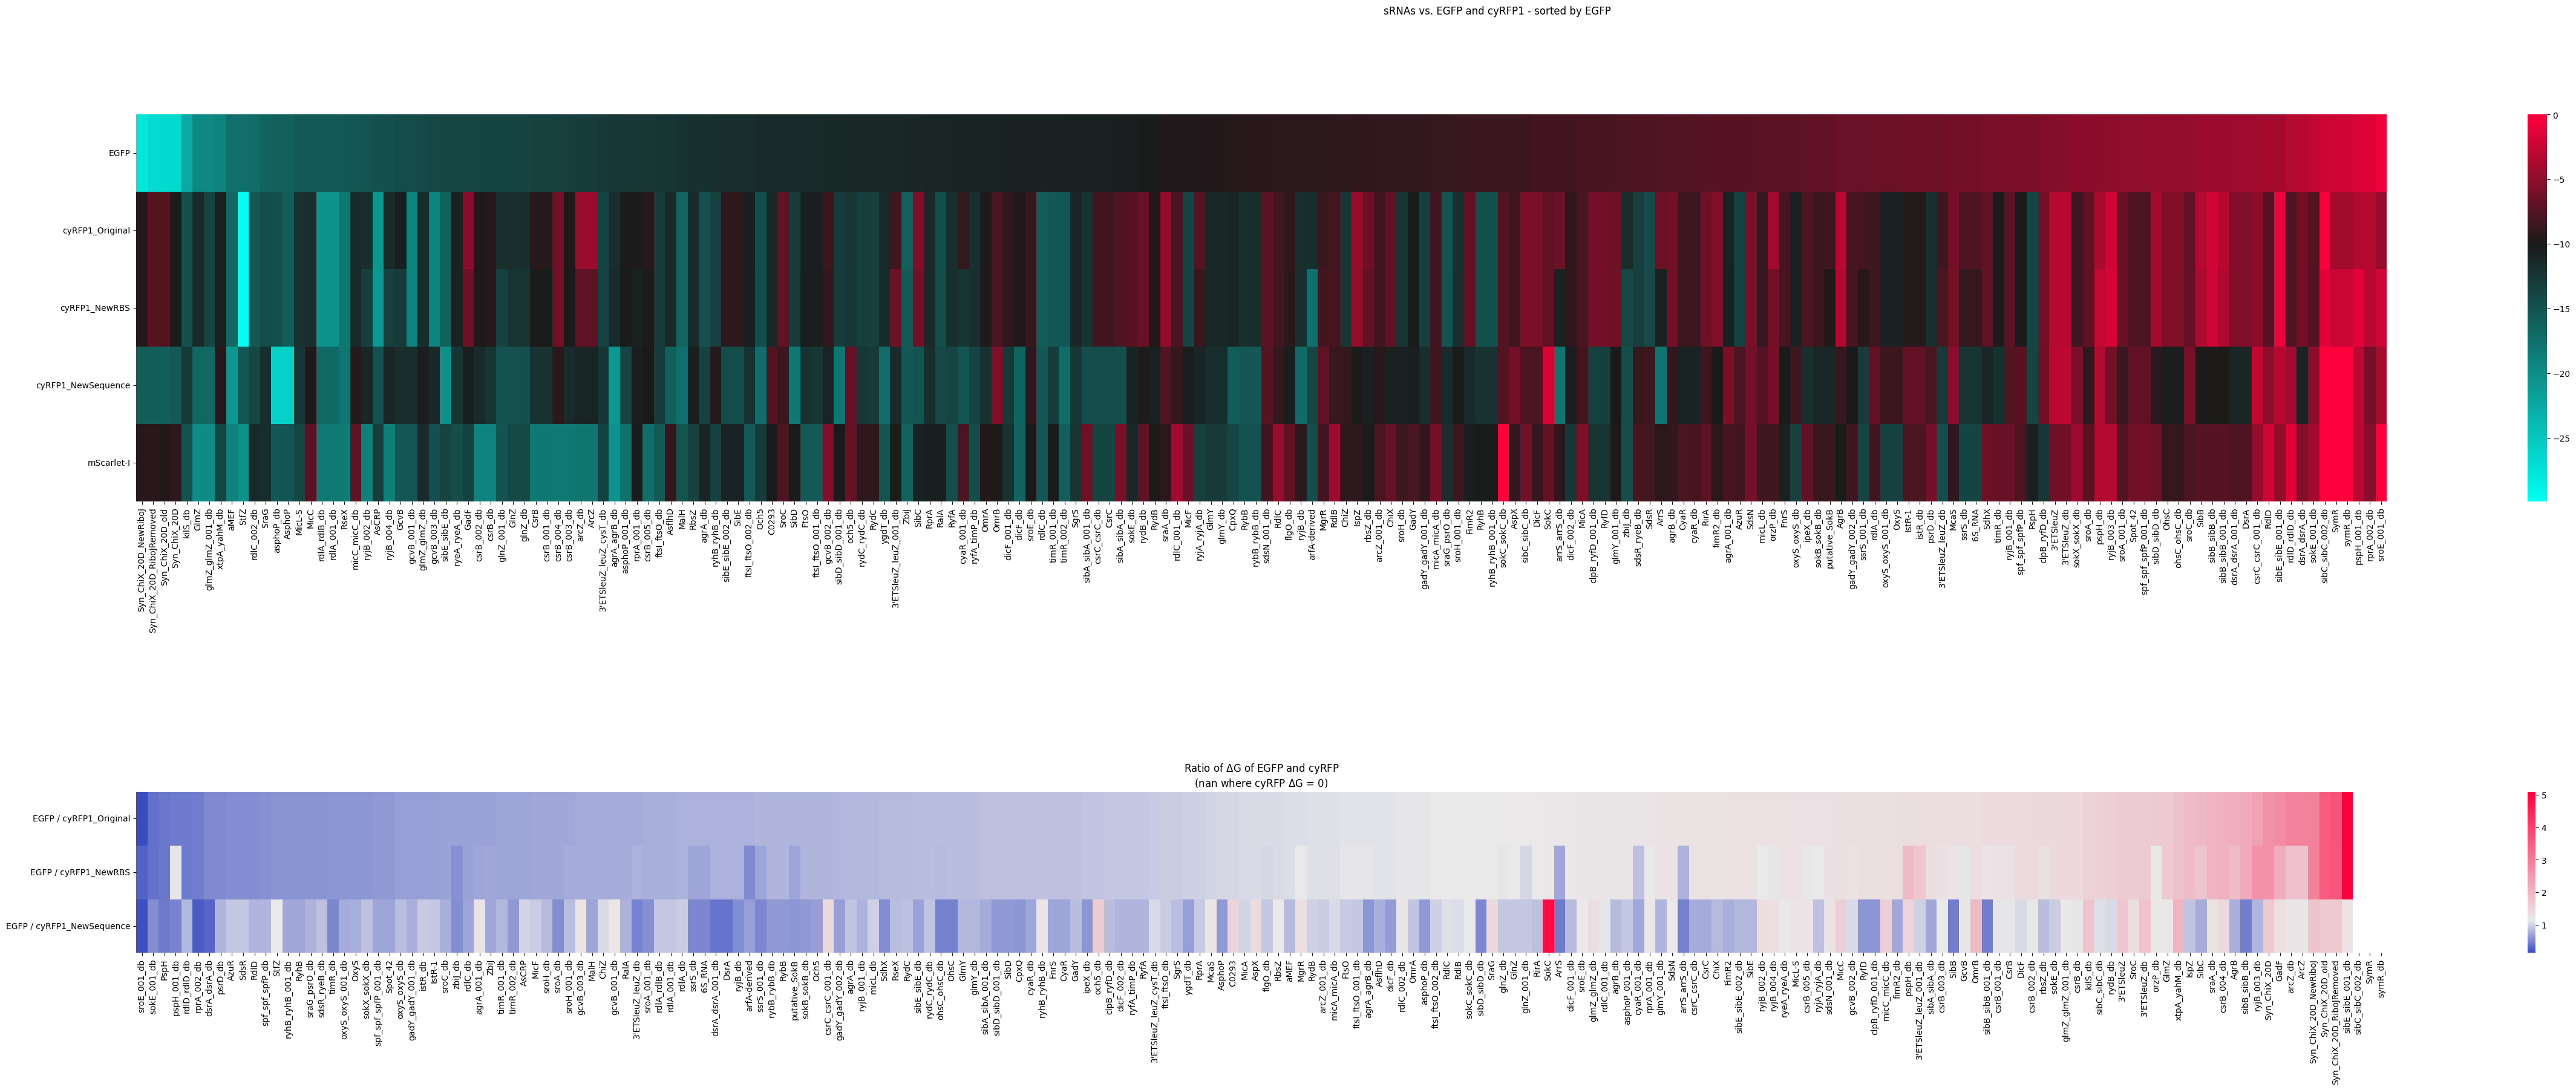

In [17]:
energies = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l.values()]).T,
                        columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))
energies = energies.sort_index(key=lambda x: x.str.lower())[sorted(energies.columns, key=lambda x: x.lower())]
energies = energies.T

fig = plt.figure(figsize=(60, 2*9))
fig.subplots_adjust(hspace=0.4)
# ax = plt.subplot(2,1,1)
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((4, 1), (3, 0))
custom_cmap = make_diverging(-energies[list(cols_fps)], center=np.max(-energies[list(cols_fps)]) - 10, 
                             center_color=center_color_d, cool_color='#00fff2')
sns.heatmap(energies.sort_values('EGFP')[list(cols_fps)].T, ax=ax1, cmap=custom_cmap)
plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

# ax = plt.subplot(2,1,2)
cols_cyrfp_ratios = [f'EGFP / {k}' for k in cols_cyrfp] 
for k, kr in zip(cols_cyrfp, cols_cyrfp_ratios):
    energies[kr] = energies['EGFP'] / energies[k]
    energies[energies[kr] < -300] = np.nan
energies = energies.sort_values(cols_cyrfp_ratios[0])
custom_cmap = make_diverging(energies[cols_cyrfp_ratios], center=1)
sns.heatmap(energies[[f'EGFP / {k}' for k in cols_cyrfp]].T, yticklabels=[f'EGFP / {k}' for k in cols_cyrfp], xticklabels=energies.index.to_list(), 
            ax=ax2, # center=1, 
            cmap=custom_cmap)
plt.title('Ratio of $\Delta$G of EGFP and cyRFP\n(nan where cyRFP $\Delta$G = 0)')

plt.suptitle('sRNAs vs. EGFP and cyRFP1 - sorted by EGFP')

# energies = energies.drop(labels='MicC')
# ax = plt.subplot(2,1,2)
# sns.heatmap(energies)
# plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)\n(without construct MicC)')


Text(0.5, 0.98, 'sRNAs vs. EGFP and cyRFP1 - sorted by EGFP')

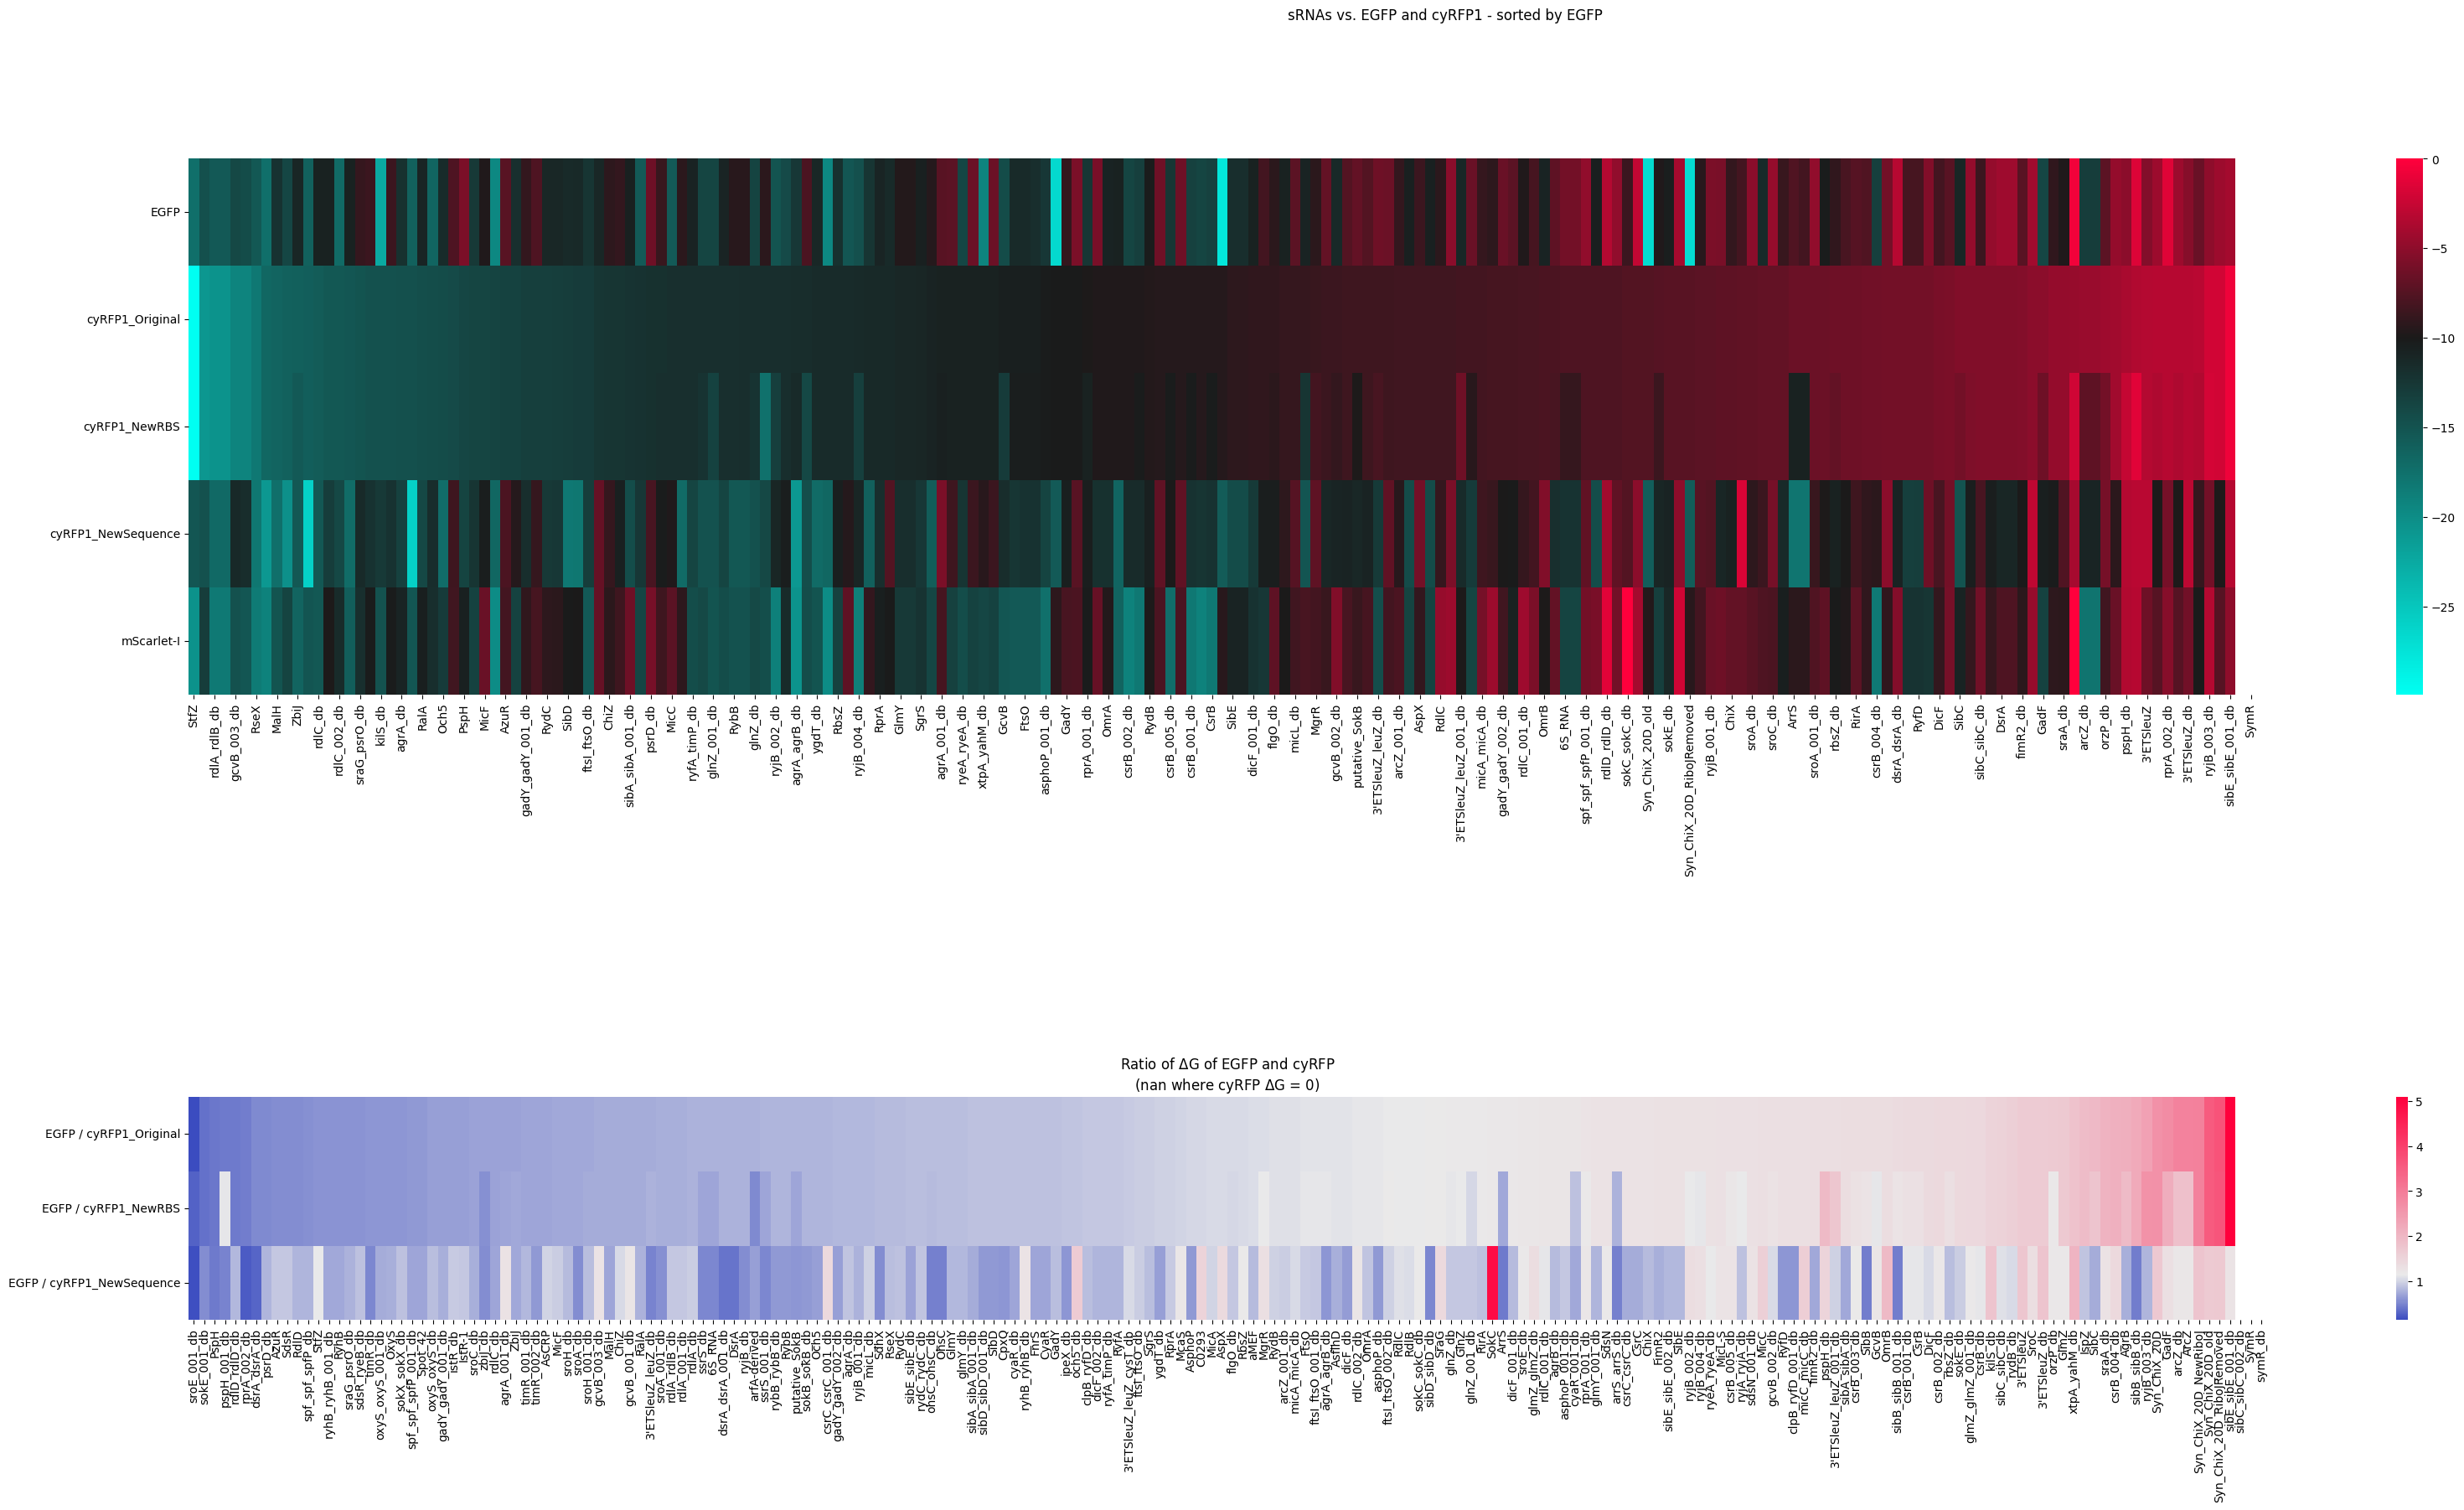

In [18]:
fig = plt.figure(figsize=(40, 2*9))
fig.subplots_adjust(hspace=0.4)
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((4, 1), (3, 0))
custom_cmap = make_diverging(-energies[list(cols_fps)], center=np.max(-energies[list(cols_fps)]) - 10, 
                             center_color=center_color_d, cool_color='#00fff2')
sns.heatmap(energies.sort_values('cyRFP1_Original')[list(cols_fps)].T, ax=ax1, cmap=custom_cmap)
plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

custom_cmap = make_diverging(energies[cols_cyrfp_ratios], center=1)
sns.heatmap(energies.sort_values(cols_cyrfp_ratios[0])[[f'EGFP / {k}' for k in cols_cyrfp]].T, yticklabels=[f'EGFP / {k}' for k in cols_cyrfp], xticklabels=energies.index.to_list(), 
            ax=ax2, # center=1, 
            cmap=custom_cmap)
plt.title('Ratio of $\Delta$G of EGFP and cyRFP\n(nan where cyRFP $\Delta$G = 0)')

plt.suptitle('sRNAs vs. EGFP and cyRFP1 - sorted by EGFP')

Text(0.5, 1.0, 'Difference (absolute) from EGFP to cyRFP $\\Delta$G')

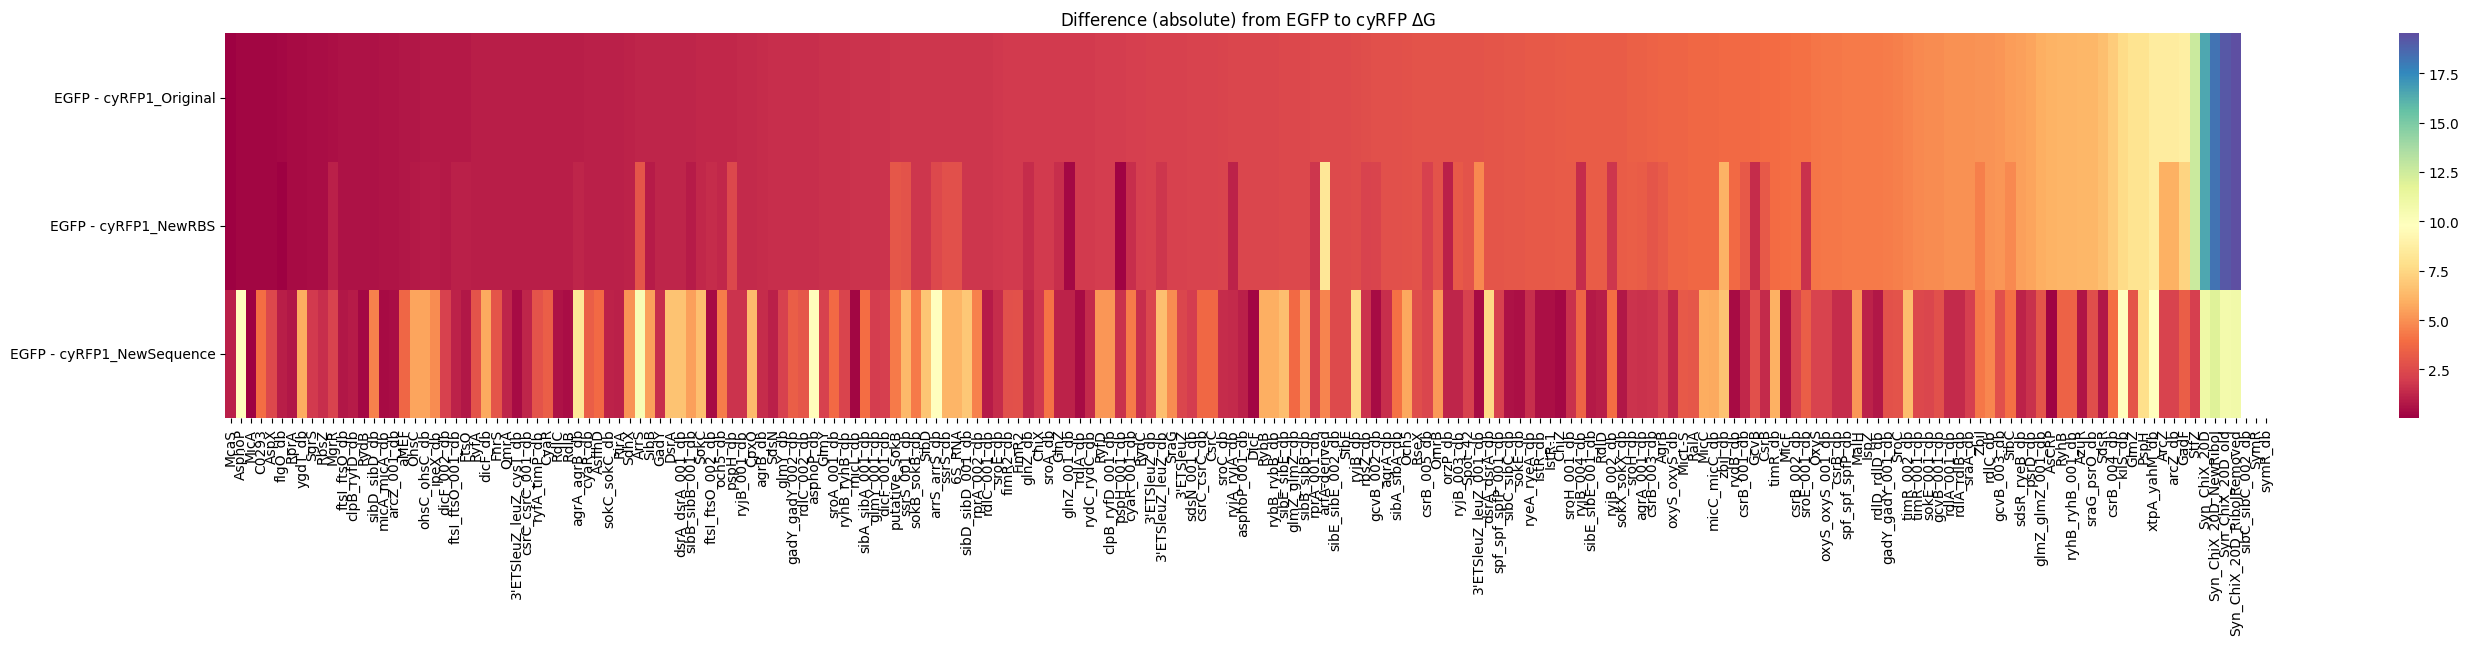

In [19]:
fig = plt.figure(figsize=(33, 5))
cols_cyrfp_diffs = [f'EGFP - {k}' for k in cols_cyrfp]
cols_cyrfp_diffs2 = [f'cyRFP1_Original - {k}' for k in cols_cyrfp if k != 'cyRFP1_Original']
for k, kd in zip(cols_cyrfp, cols_cyrfp_diffs):
    energies[kd] = np.abs(energies['EGFP'] - energies[k])
for k, kd in zip([s for s in cols_cyrfp if s != 'cyRFP1_Original'], cols_cyrfp_diffs2):
    energies[kd] = np.abs(energies['cyRFP1_Original'] - energies[k])
energies = energies.sort_values(cols_cyrfp_diffs[0])
sns.heatmap(energies[cols_cyrfp_diffs].T, yticklabels=cols_cyrfp_diffs, xticklabels=energies.index.to_list(), cmap='Spectral')
plt.title('Difference (absolute) from EGFP to cyRFP $\Delta$G')

Text(0.5, 1.0, 'Ratio from new to old cyRFP $\\Delta$G')

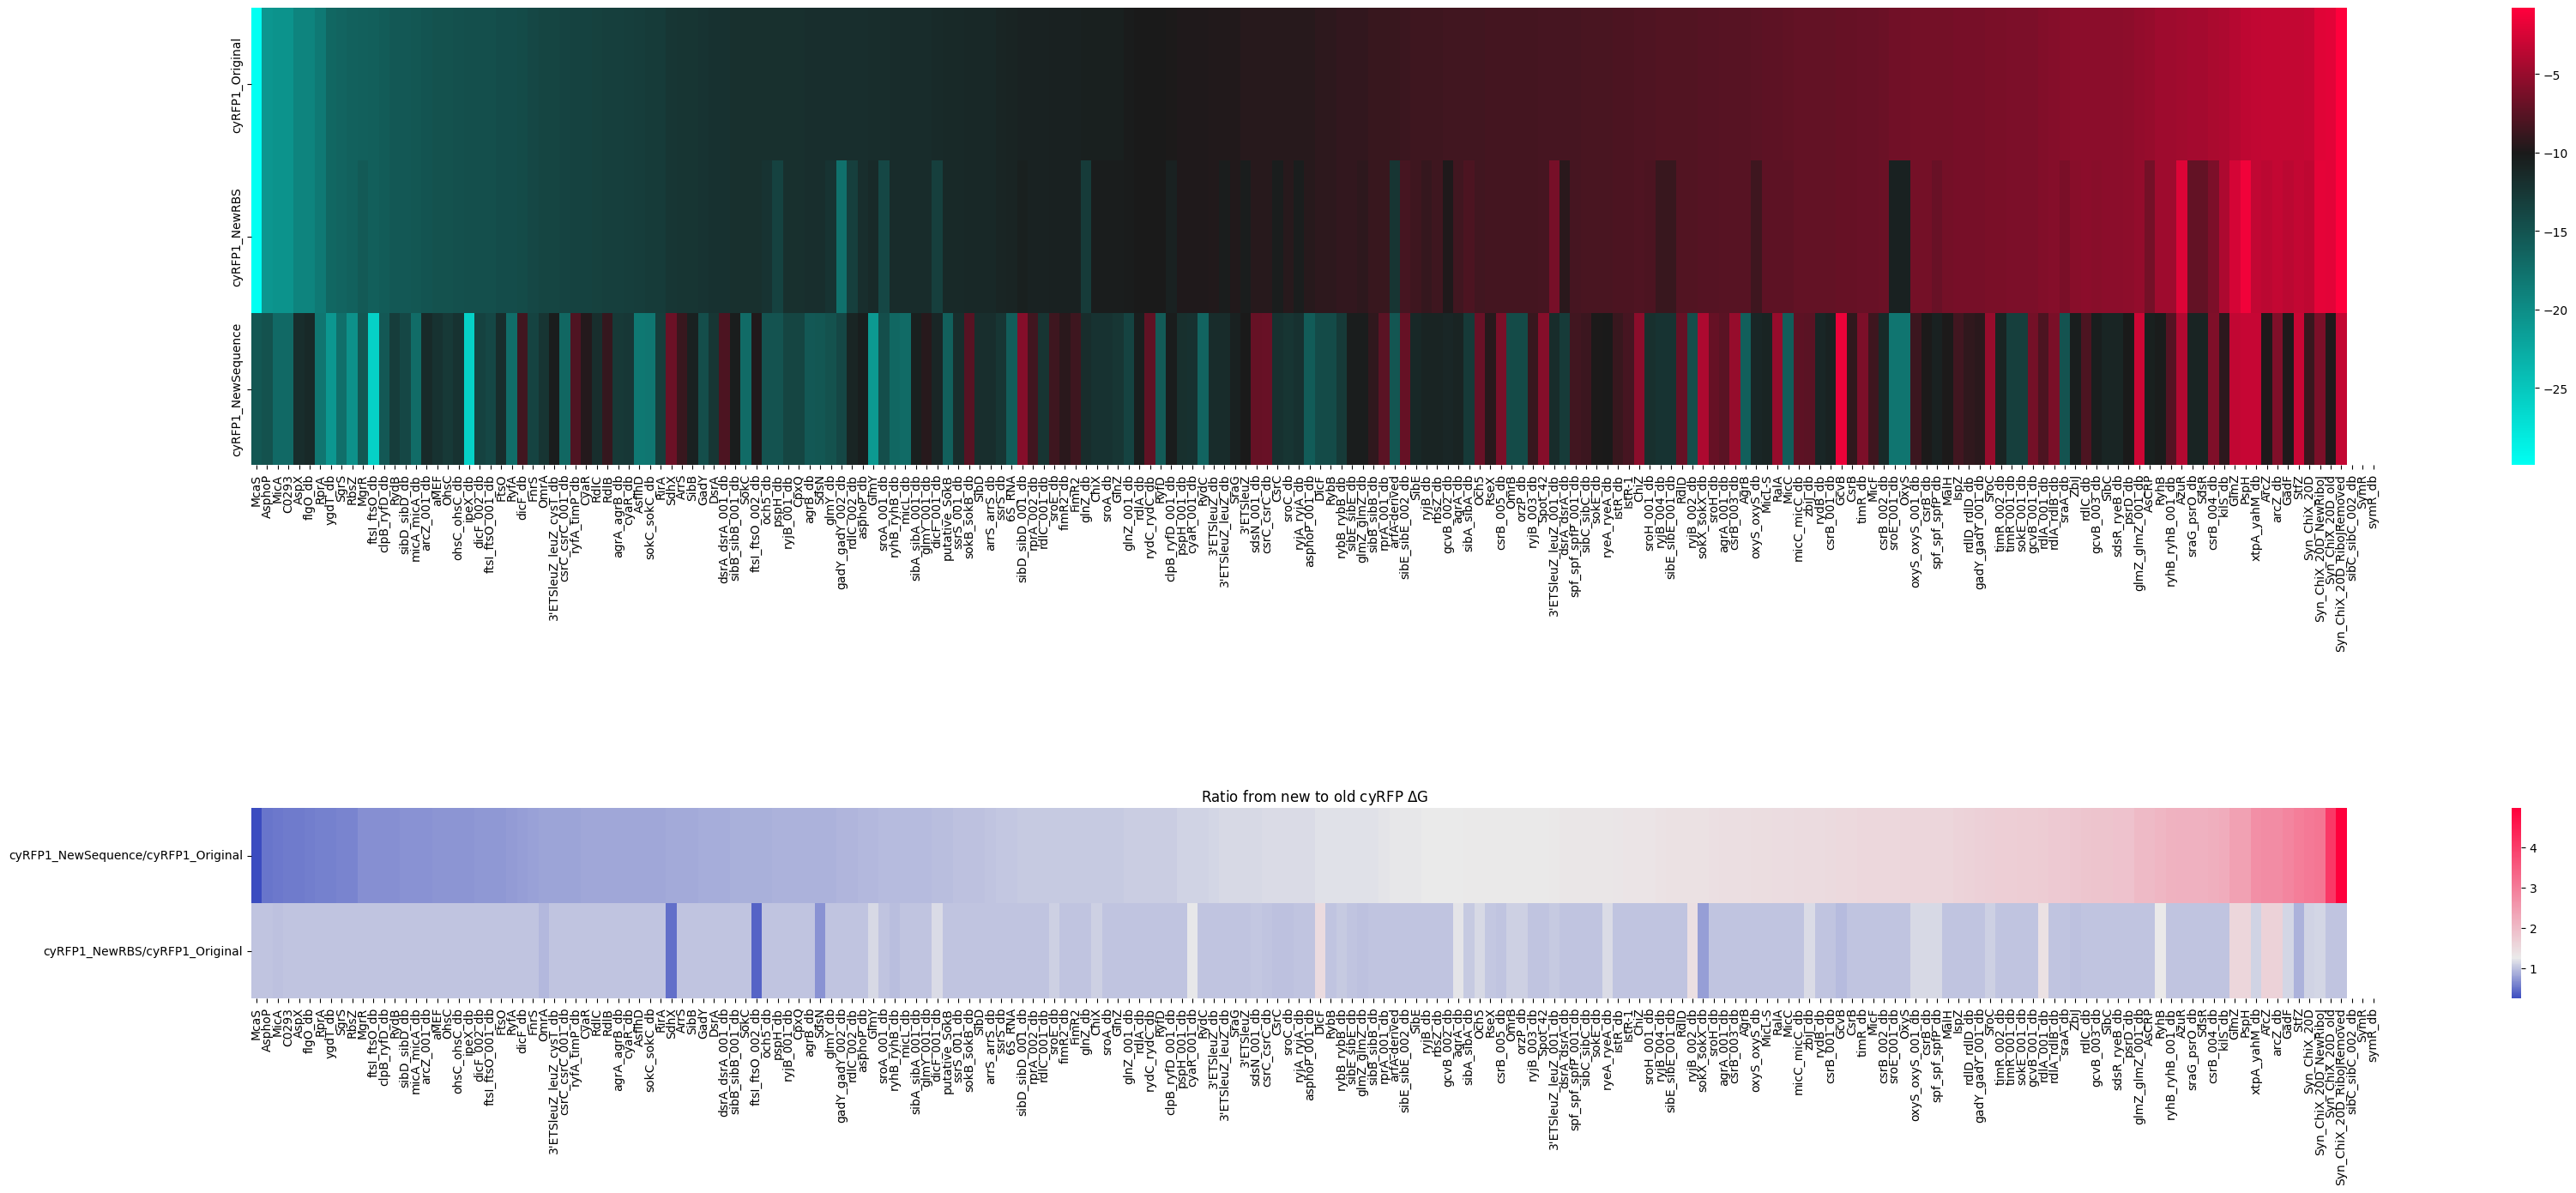

In [20]:
fig = plt.figure(figsize=(40, 5*len(cols_cyrfp)))
fig.subplots_adjust(hspace=0.4)
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((4, 1), (3, 0))
custom_cmap = make_diverging(-energies[cols_cyrfp], center=np.max(-energies[cols_cyrfp]) - 10, 
                            #  center_color=center_color_d, cool_color='#5f00ff', warm_color='#ffe3aa')
                             center_color=center_color_d, cool_color='#00fff2')
sns.heatmap(energies.sort_values(by=cols_cyrfp[0])[cols_cyrfp].T, xticklabels=energies.index.to_list(), cmap=custom_cmap, # cmap='Spectral',
            ax=ax1)
plt.title('Difference between new and old cyRFP1 $\Delta$G')

cols_cyrfp_newold = [f'{k}/cyRFP1_Original' for k in ['cyRFP1_NewSequence', 'cyRFP1_NewRBS']]
for k, kd in zip(['cyRFP1_NewSequence', 'cyRFP1_NewRBS'], cols_cyrfp_newold):
    energies[kd] = energies[k] / energies['cyRFP1_Original']
custom_cmap = make_diverging(energies[cols_cyrfp_newold], center=1)
sns.heatmap(energies.sort_values(by=cols_cyrfp_newold[0])[cols_cyrfp_newold].T, yticklabels=cols_cyrfp_newold, xticklabels=energies.index.to_list(), cmap=custom_cmap,
            ax=ax2)
plt.title('Ratio from new to old cyRFP $\Delta$G')

### Binding positions on new and old cyRFPs

In [21]:
binding_pos_q = {}
for fp in cols_fps:
    binding_pos_q[fp] = np.array([np.array(list(v[fp]['hybridDPfull'].split('&')[1])) == ')' if v[fp]['E'] else np.zeros(len(fps[fp]), dtype=bool) for v in sim_data_l.values()])
    binding_pos_q[fp] = pd.DataFrame(data=binding_pos_q[fp].T, columns=sim_data_l.keys()).T
                        # columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))
    

In [22]:
def get_spot_probabilities(dir, prefix, queries, targets, col_name='spotProb'):
    spots = {}
    list1 = queries
    list2 = targets
    if prefix == 't':
        list1 = targets
        list2 = queries
    for j in range(len(list1)):
        for i, s in enumerate(list2):
            i_t, i_q = (i+1, j+1) if prefix == 'q' else (j+1, i+1)
            r = pd.read_csv(os.path.join(dir, f'{prefix}-t{i_t}q{i_q}.csv'), delimiter=';')
            if s not in spots.get(list1[j], r).columns:
                curr_spots = pd.concat([spots.get(list1[j], r), r.rename(columns={col_name: s})[s]], axis=1)
                curr_spots[curr_spots.isna()] = 0
                spots[list1[j]] = curr_spots
            else:
                print(f'{s} would have been duplicated')
        # spots[cols[j]] = spots[cols[j]].T.drop_duplicates().T
    return spots


fps_spot = get_spot_probabilities(os.path.join(top_dir, 'fps_spot'), 'q', cols_fps, srnas.keys())
fps_mine = get_spot_probabilities(os.path.join(top_dir, 'fps_mine'), 'q', cols_fps, srnas.keys(), col_name='minE')

#### Heatmap

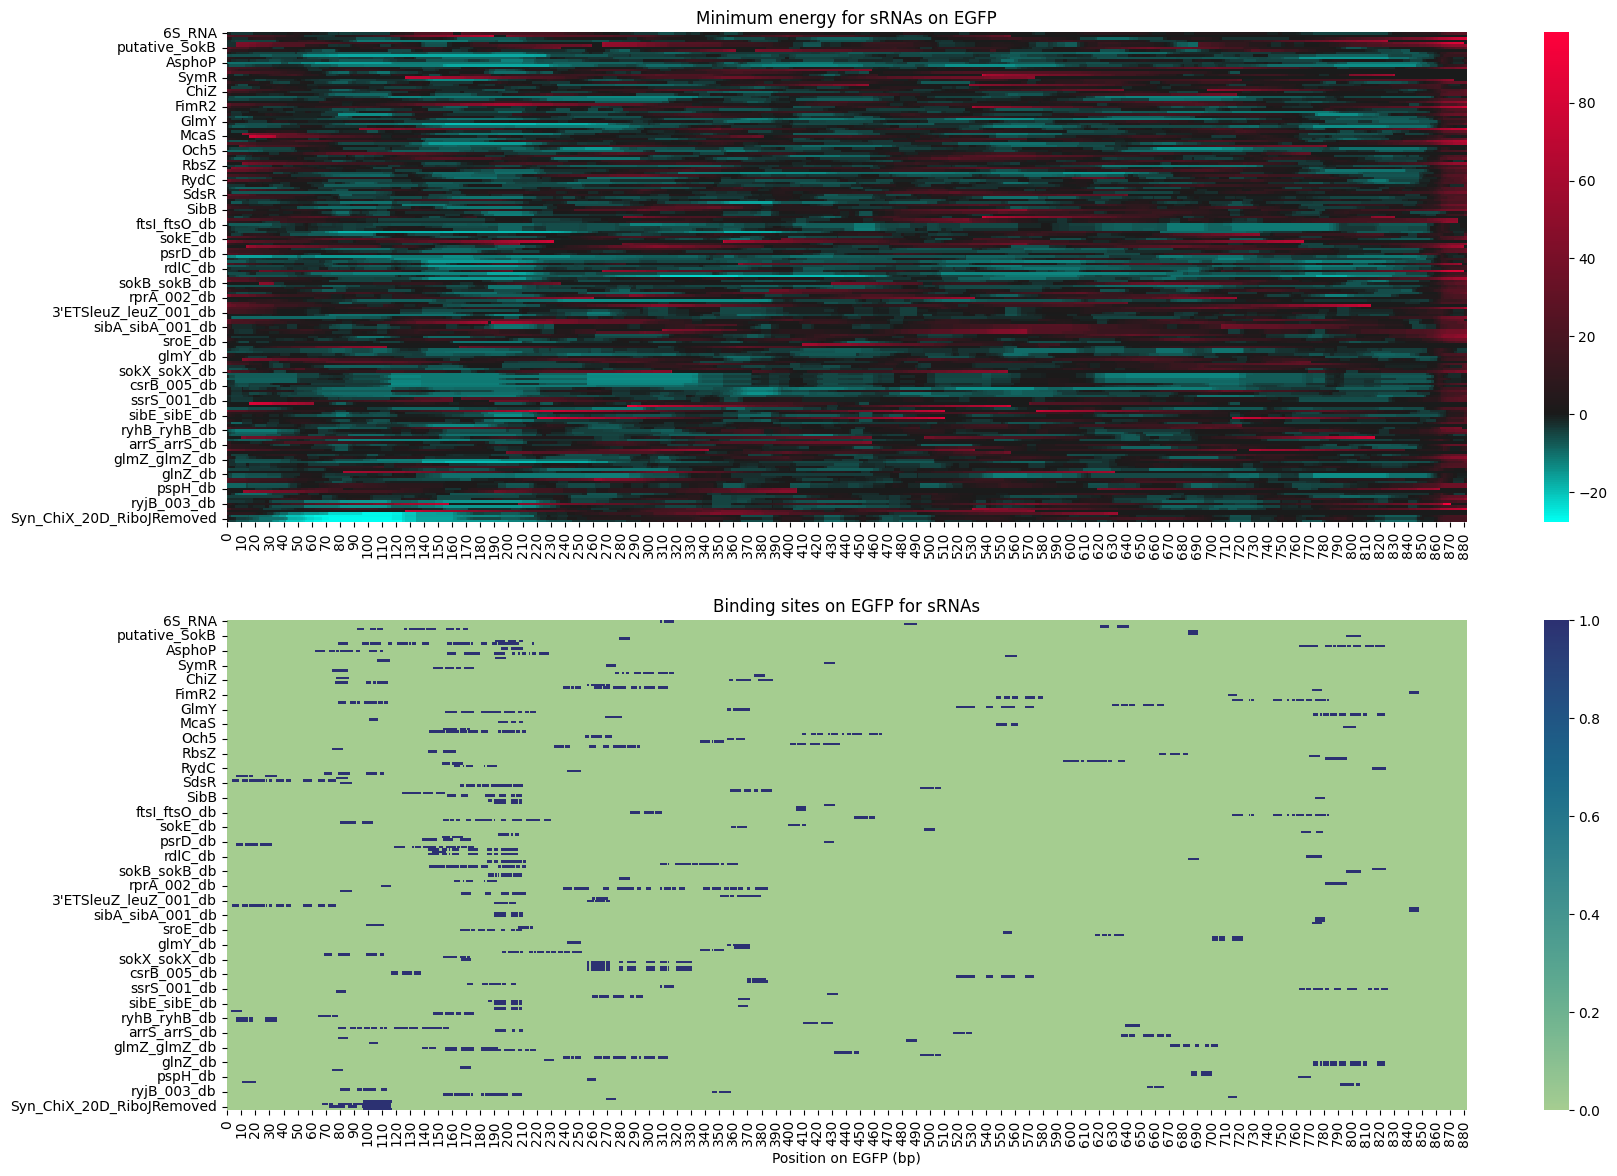

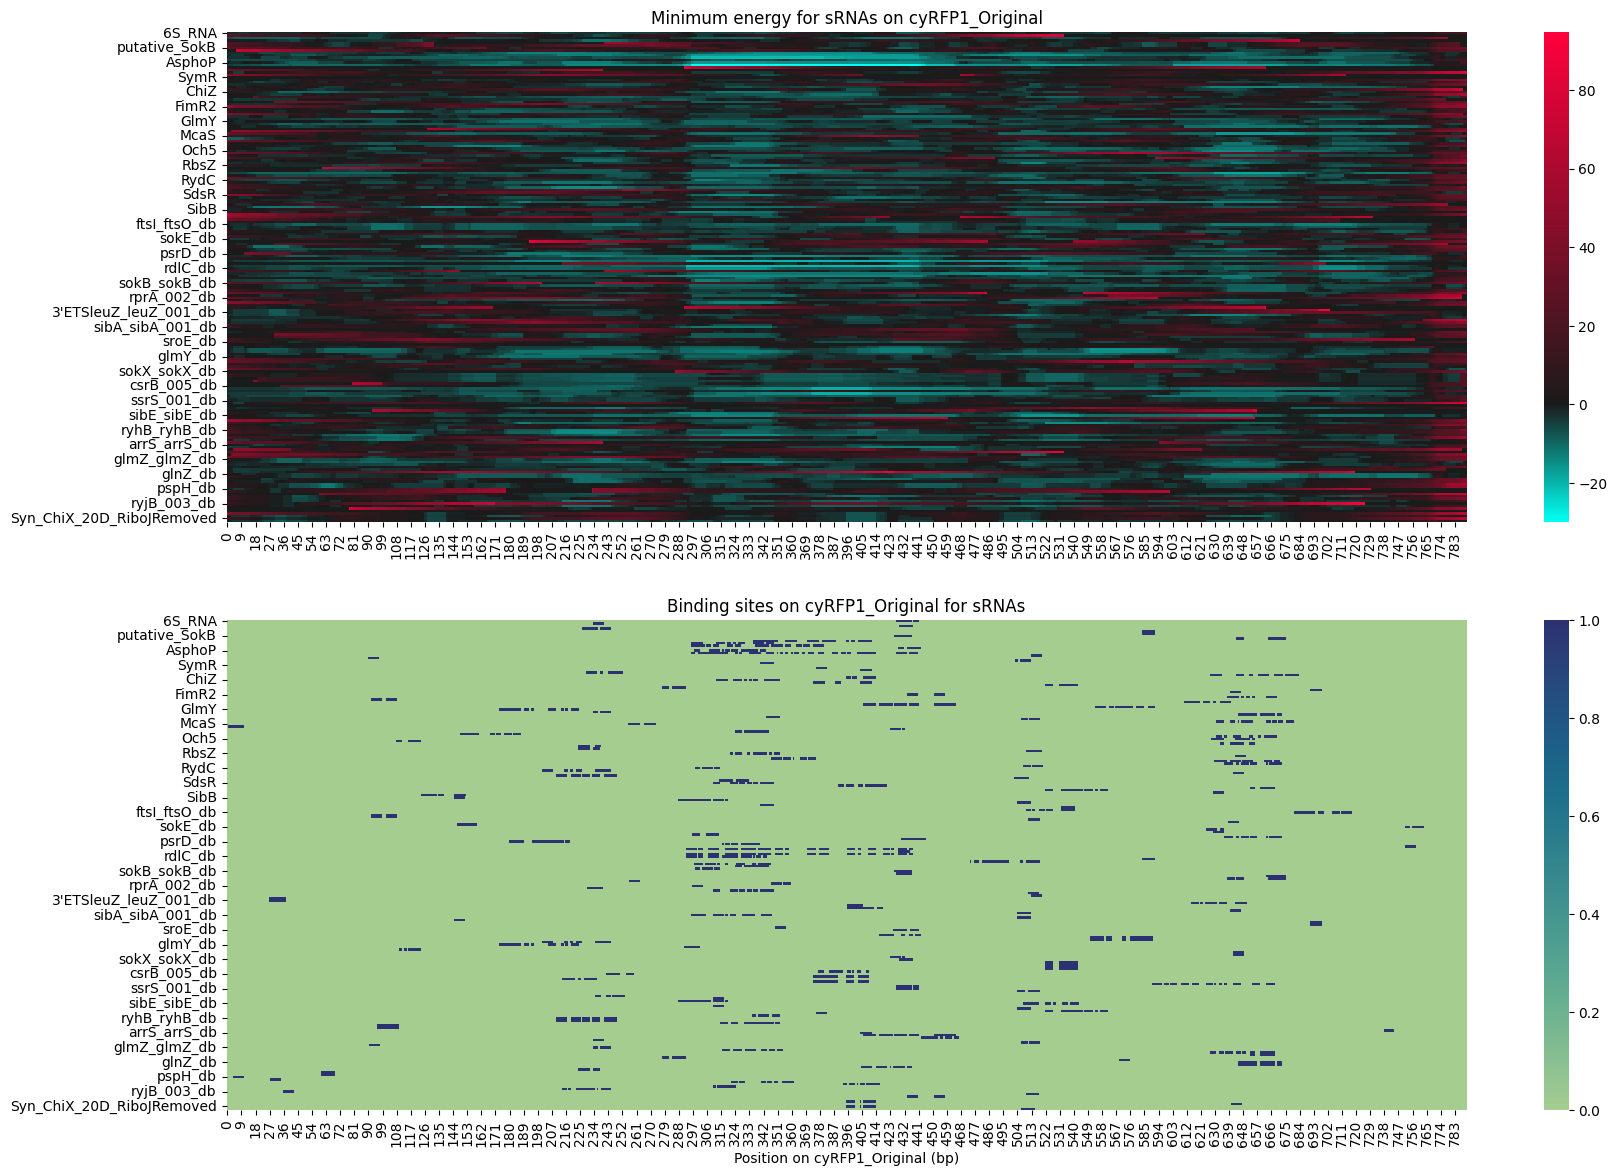

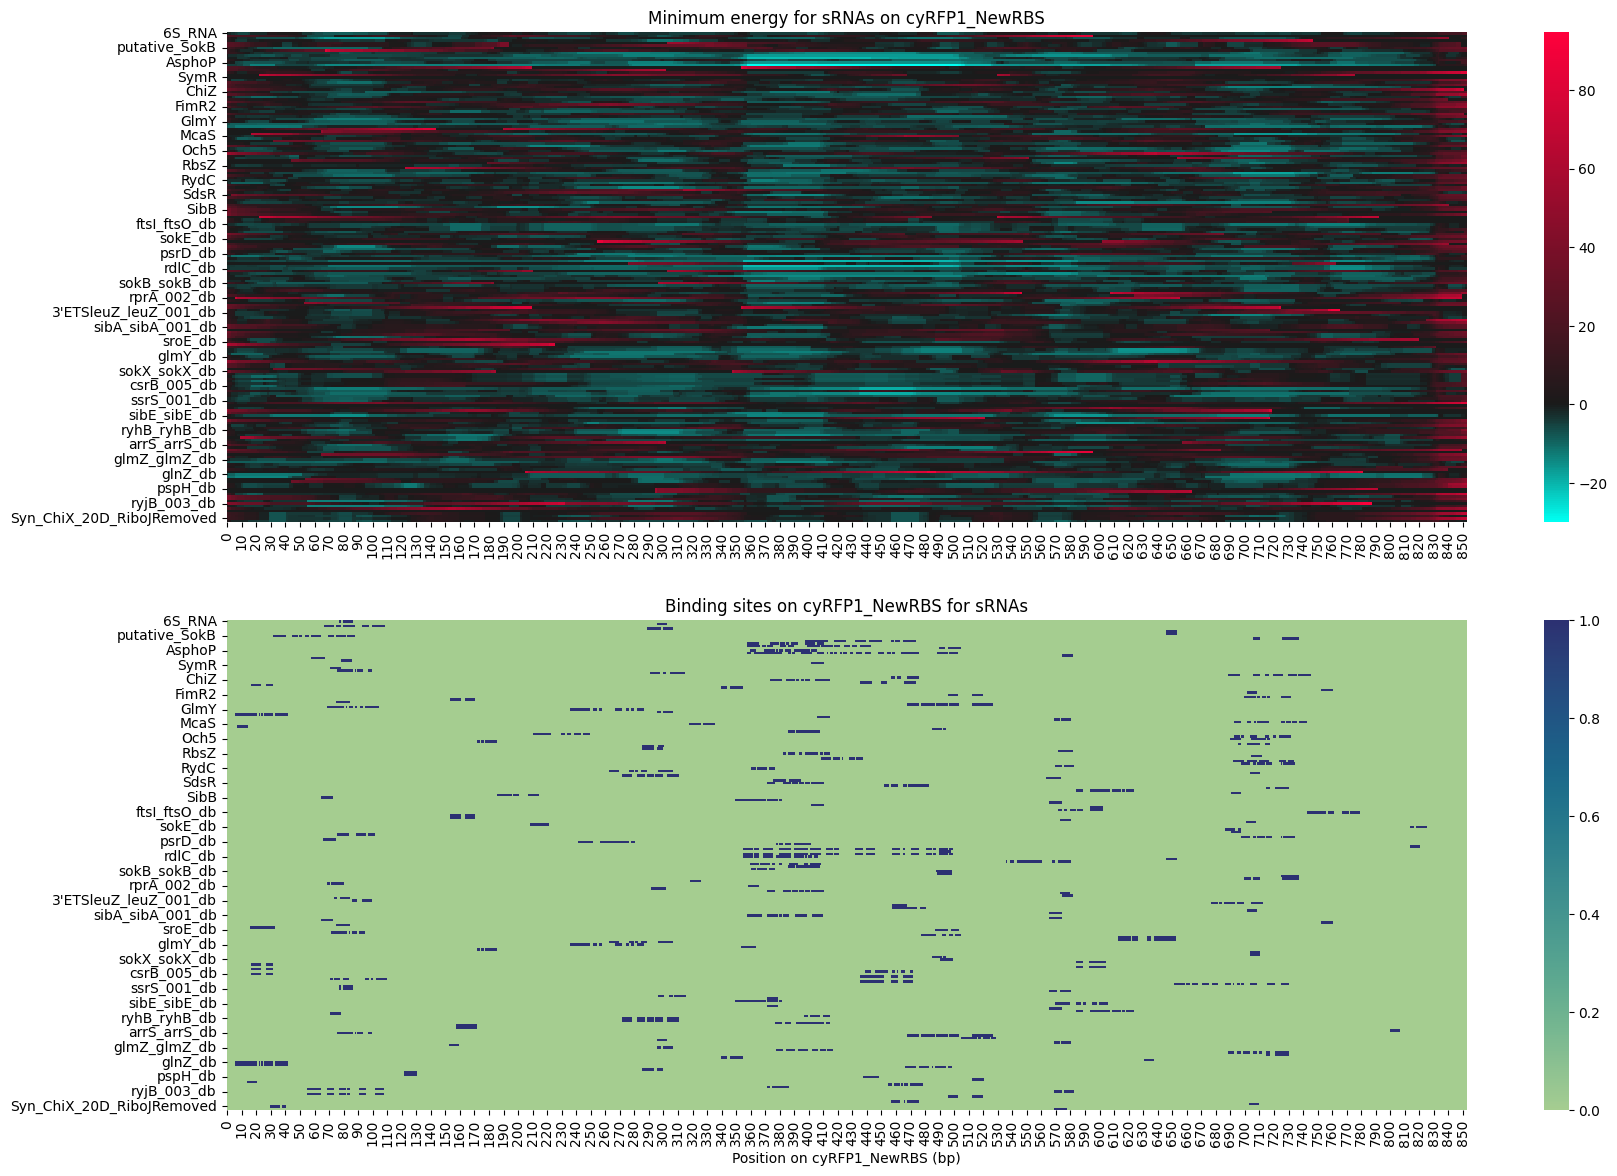

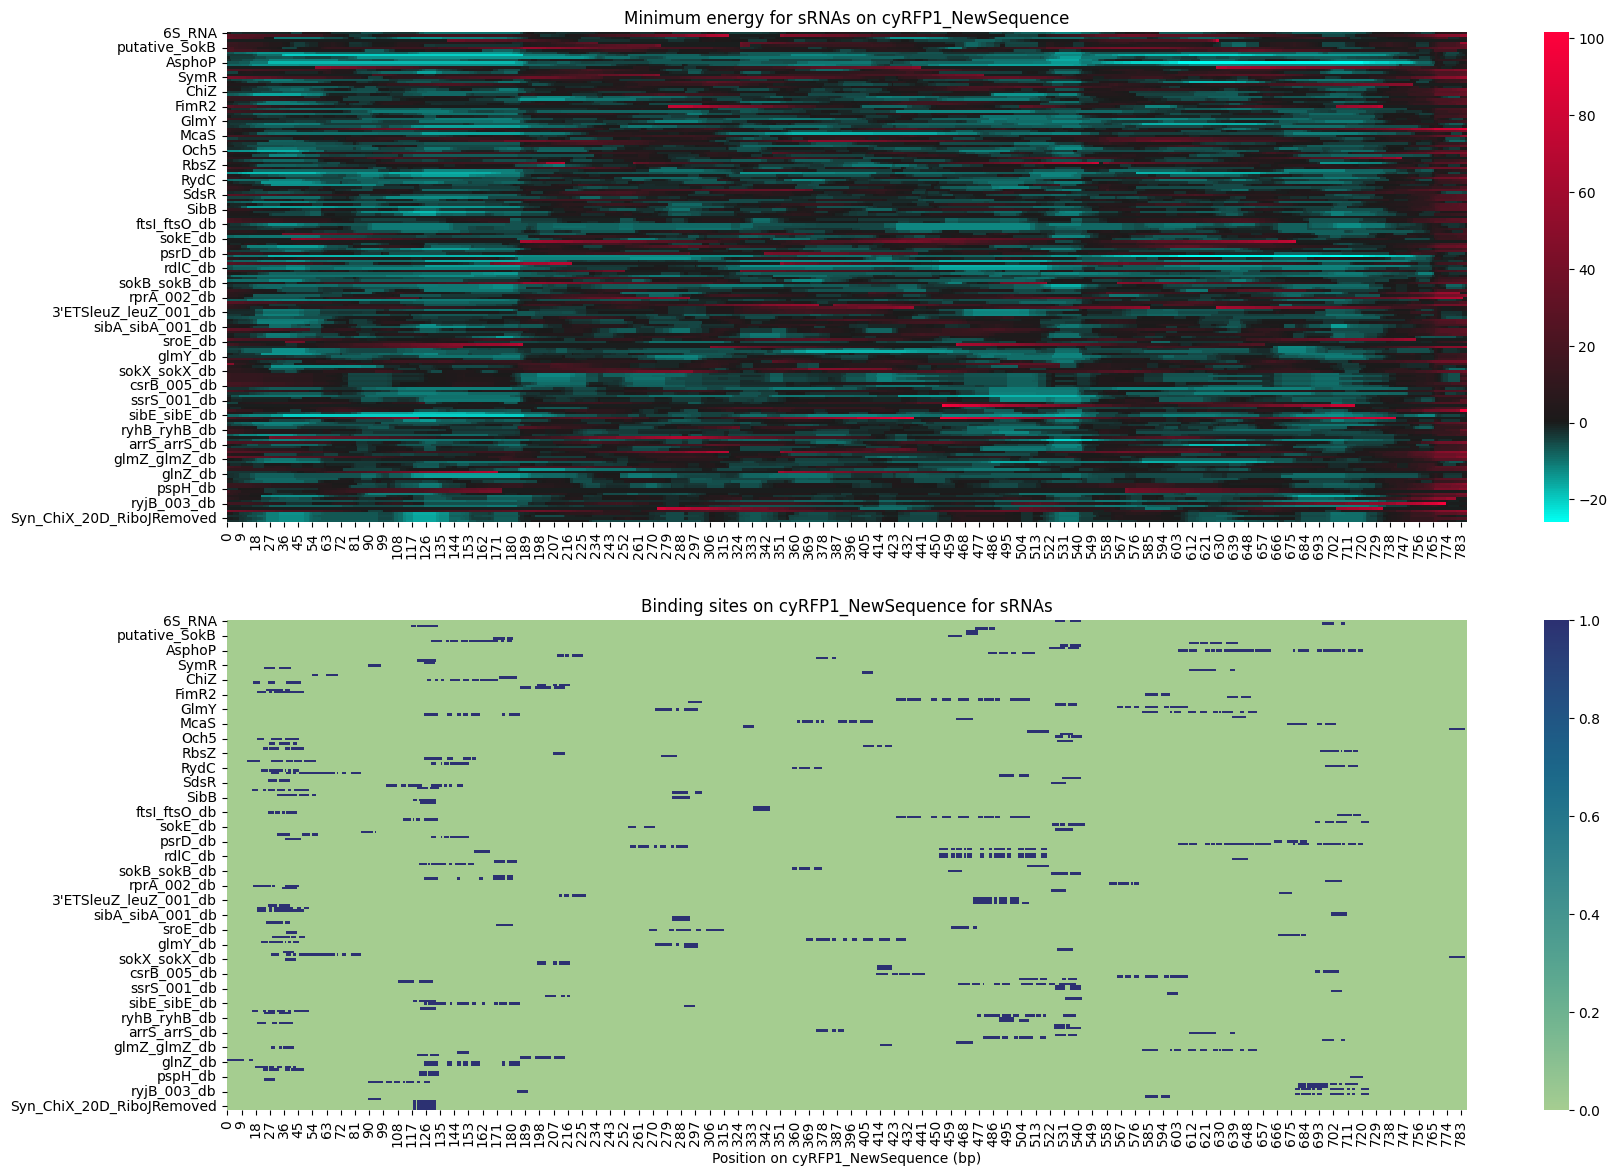

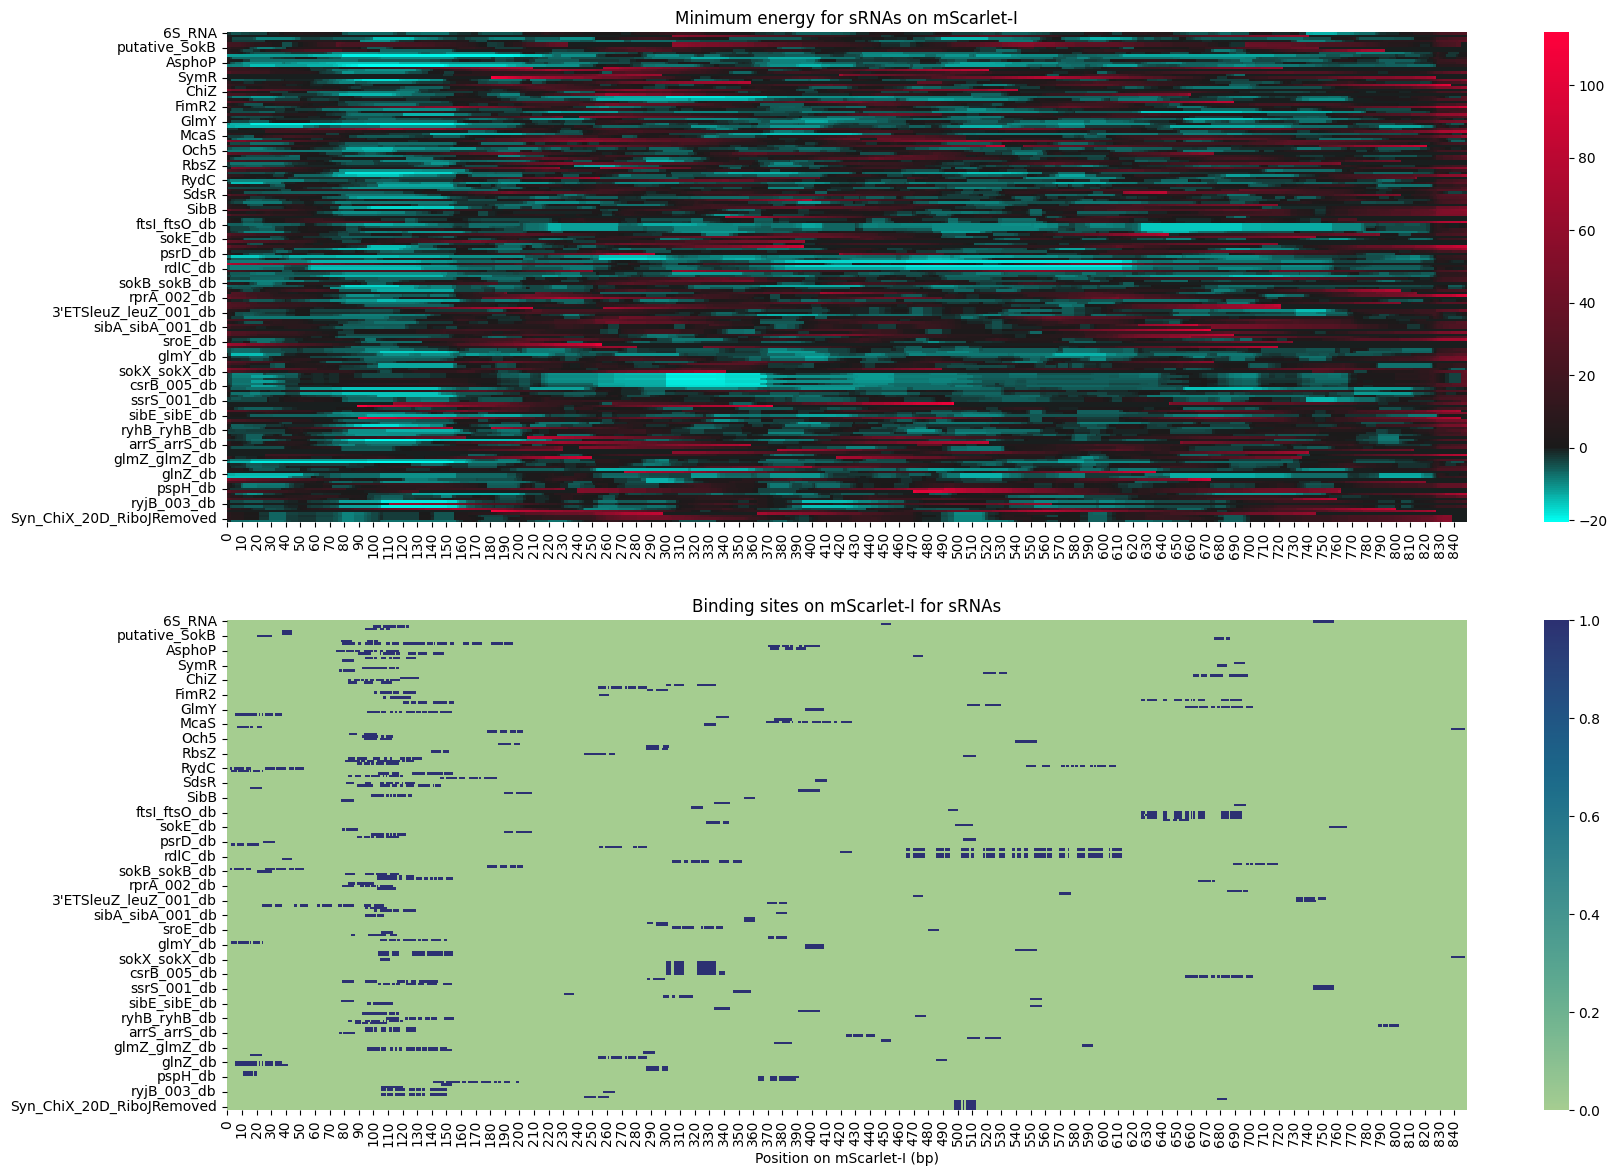

In [23]:
for i in range(len(cols_fps)):

    plt.figure(figsize=(20, 7*2))
    ax = plt.subplot(2,1,1)
    custom_cmap = make_diverging(-fps_mine[cols_fps[i]][srnas.keys()], center=-np.min(fps_mine[cols_fps[i]][srnas.keys()]), center_color=center_color_d, cool_color='#00fff2')
    sns.heatmap(fps_mine[cols_fps[i]][srnas.keys()].T, cmap=custom_cmap)
    plt.title(f'Minimum energy for sRNAs on {cols_fps[i]}')
    # ax = plt.subplot(2,1,1)
    # sns.heatmap(fps_spot[cols_fps[i]][srnas.keys()].T, cmap='viridis')
    # plt.title(f'Spot probabilities for sRNAs on {cols_fps[i]}')

    ax = plt.subplot(2,1,2)
    sns.heatmap(binding_pos_q[cols_fps[i]].T[srnas.keys()].T, cmap='crest')
    plt.xlabel(f'Position on {cols_fps[i]} (bp)')
    plt.title(f'Binding sites on {cols_fps[i]} for sRNAs')


#### Clustered

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: Us

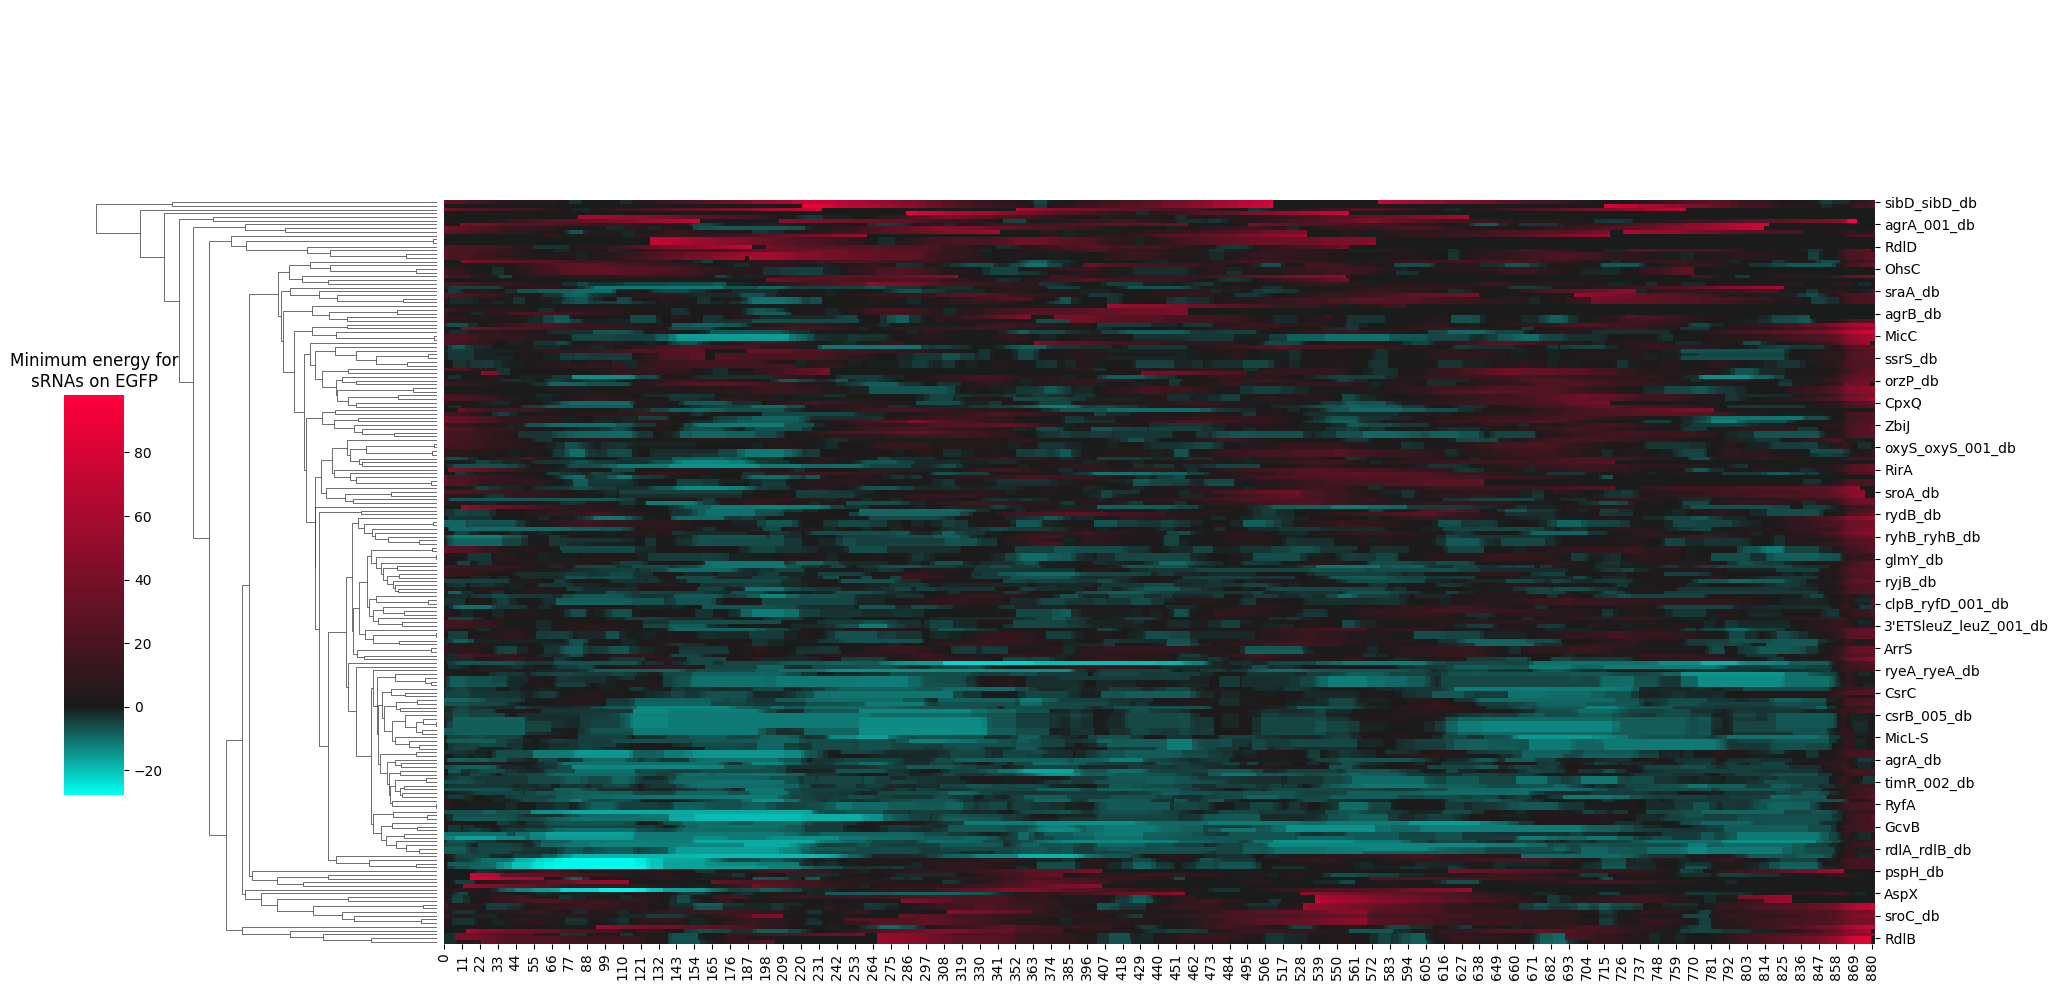

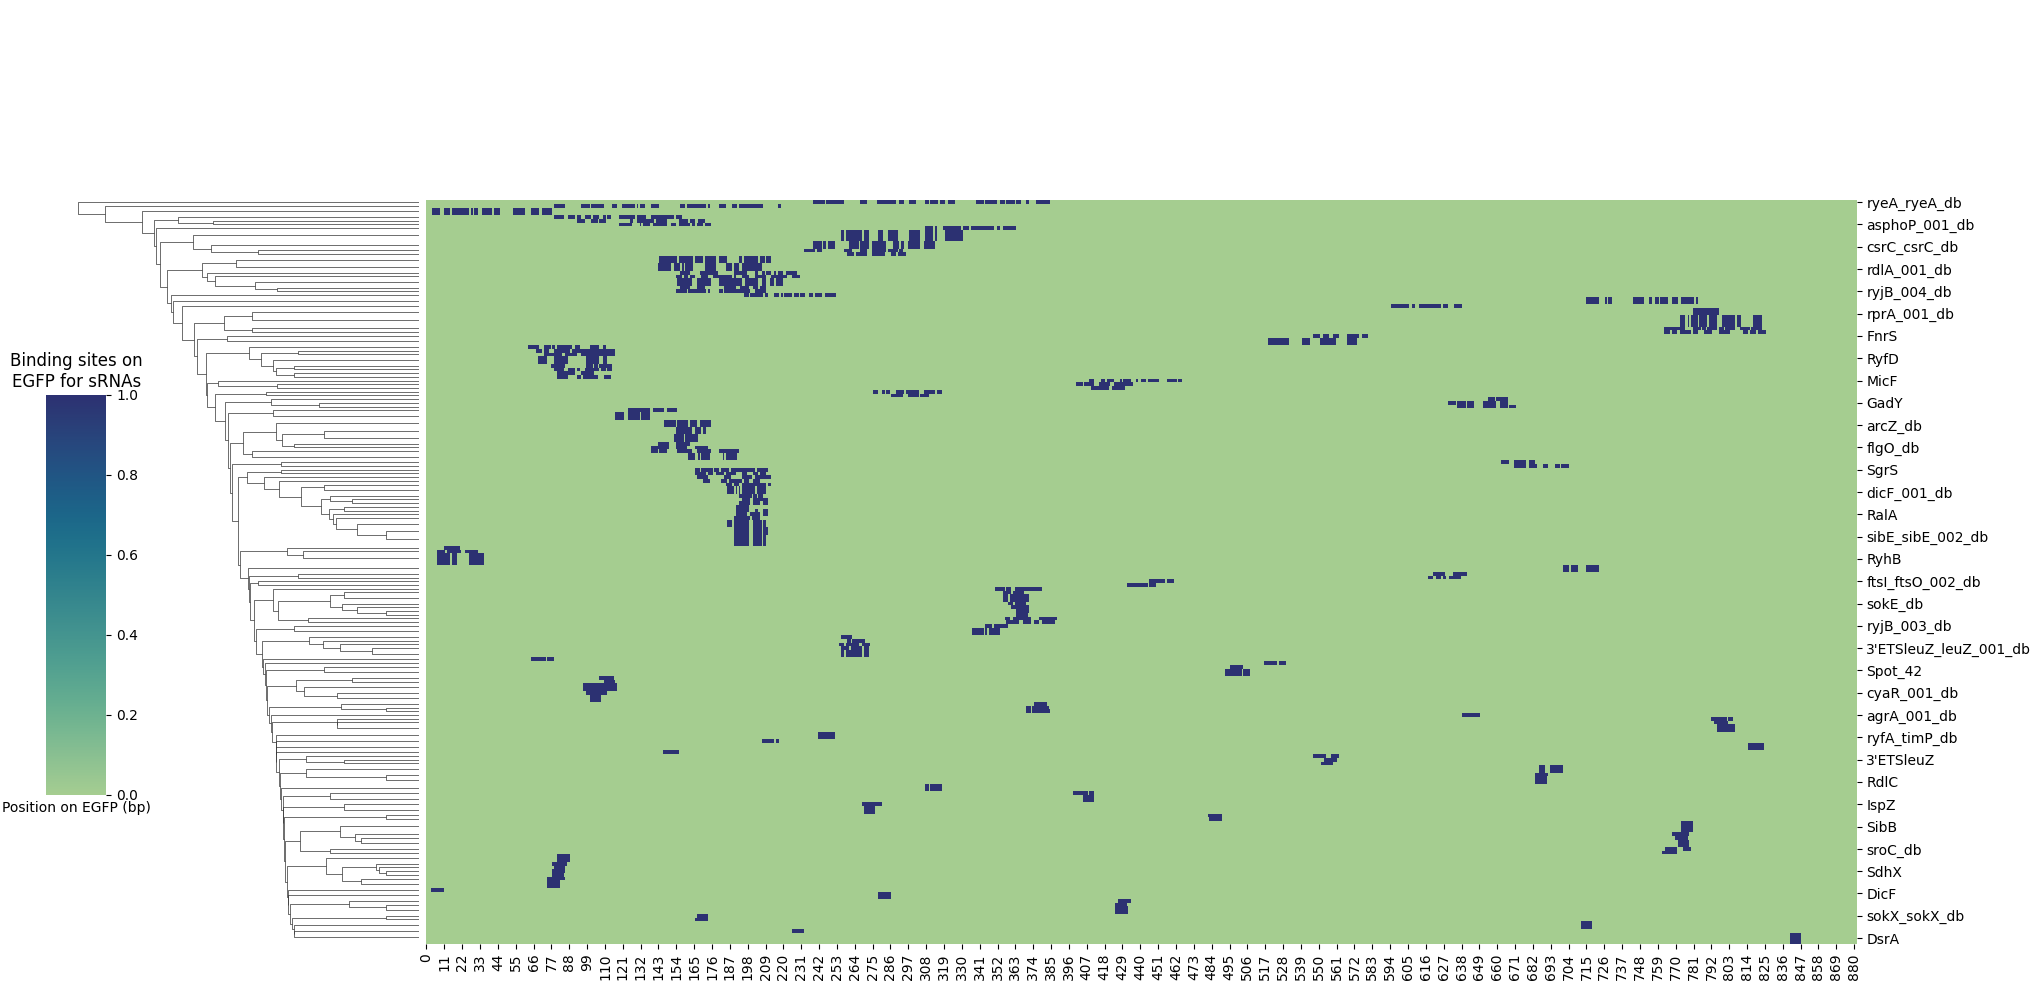

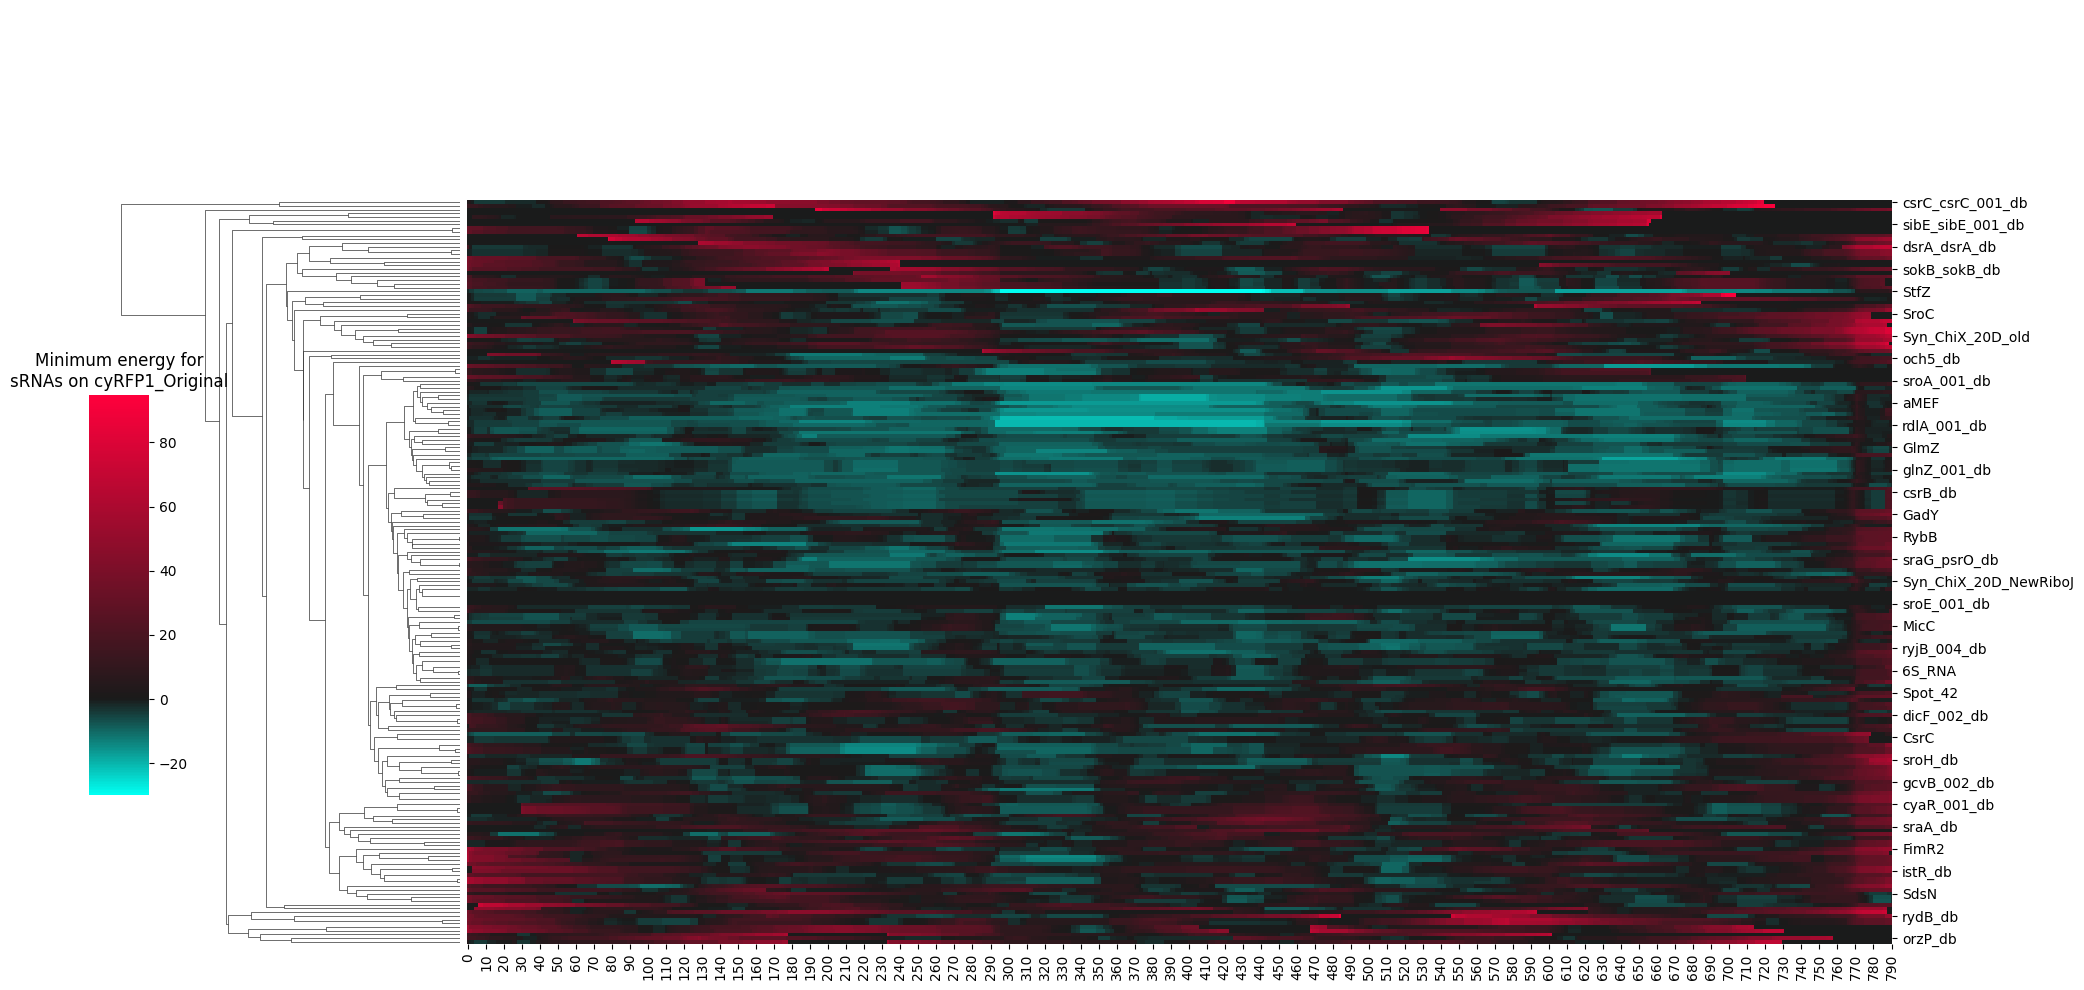

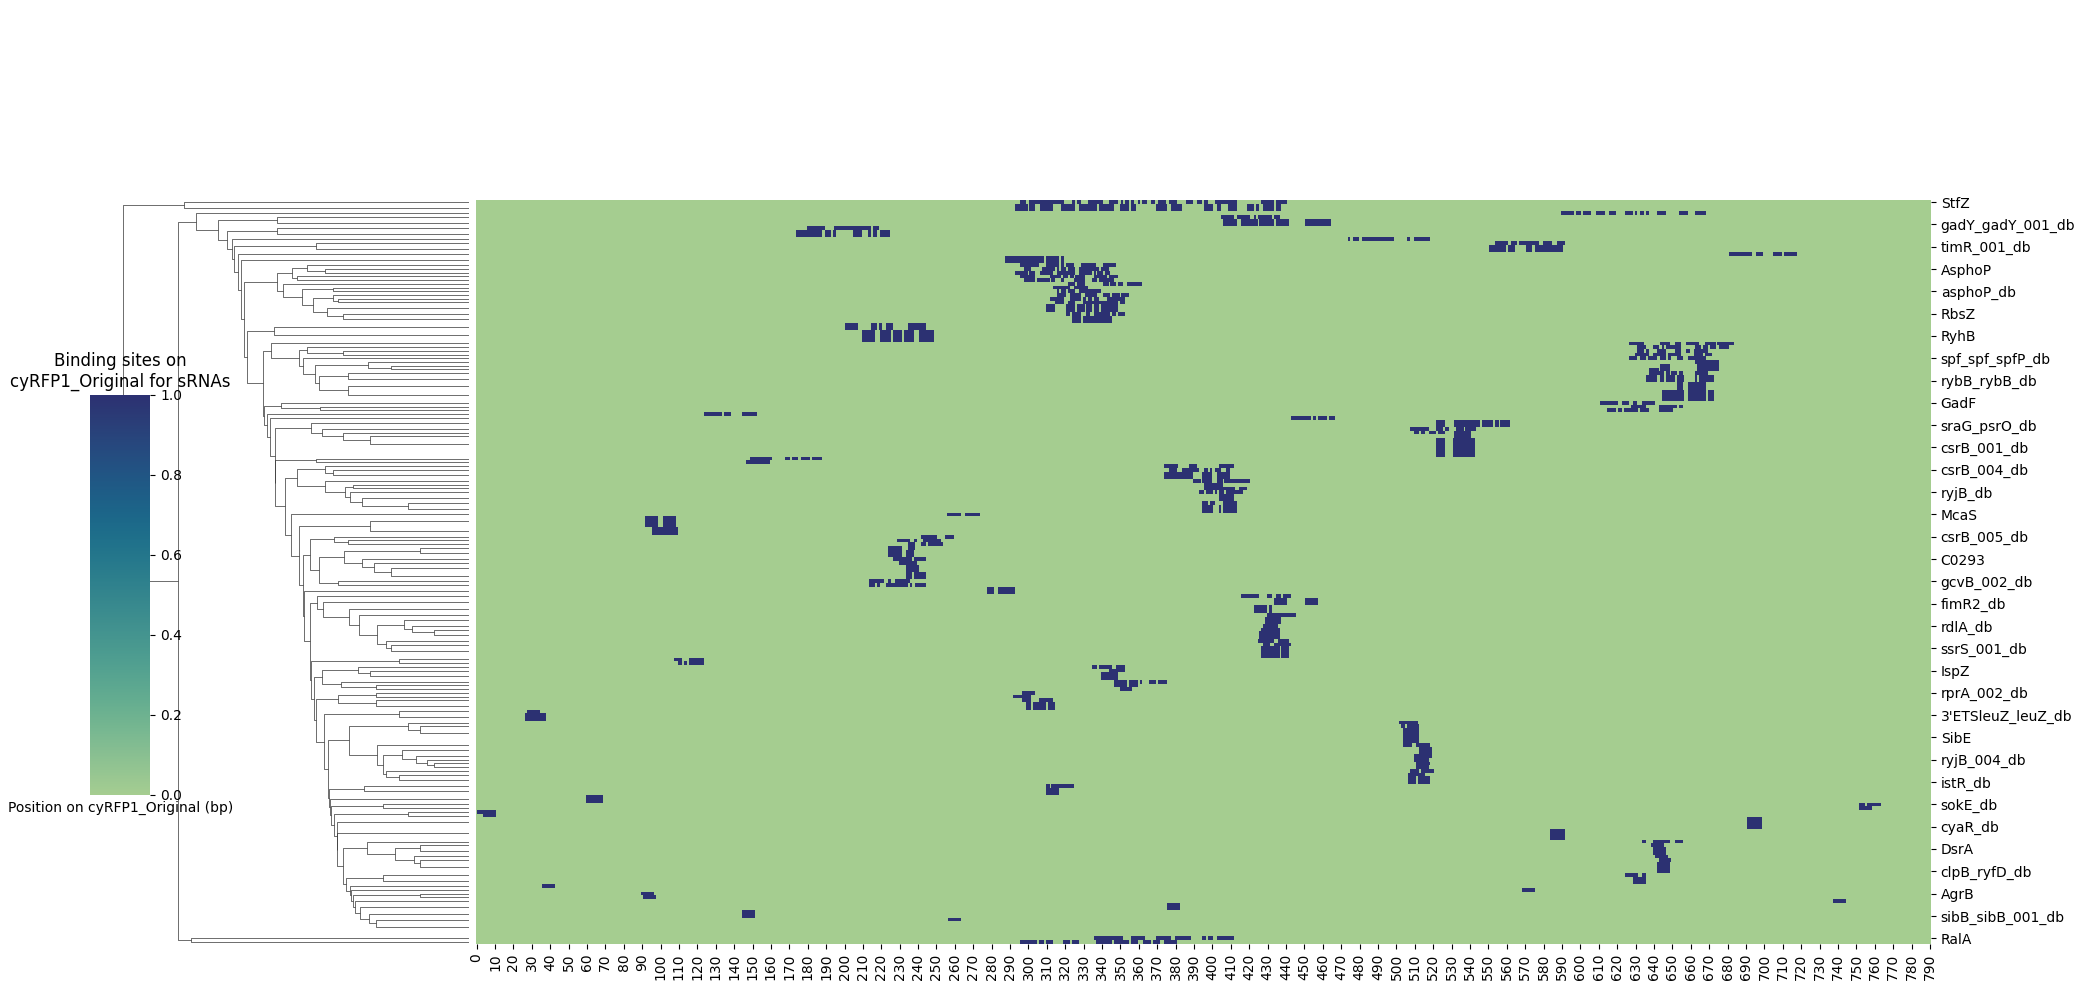

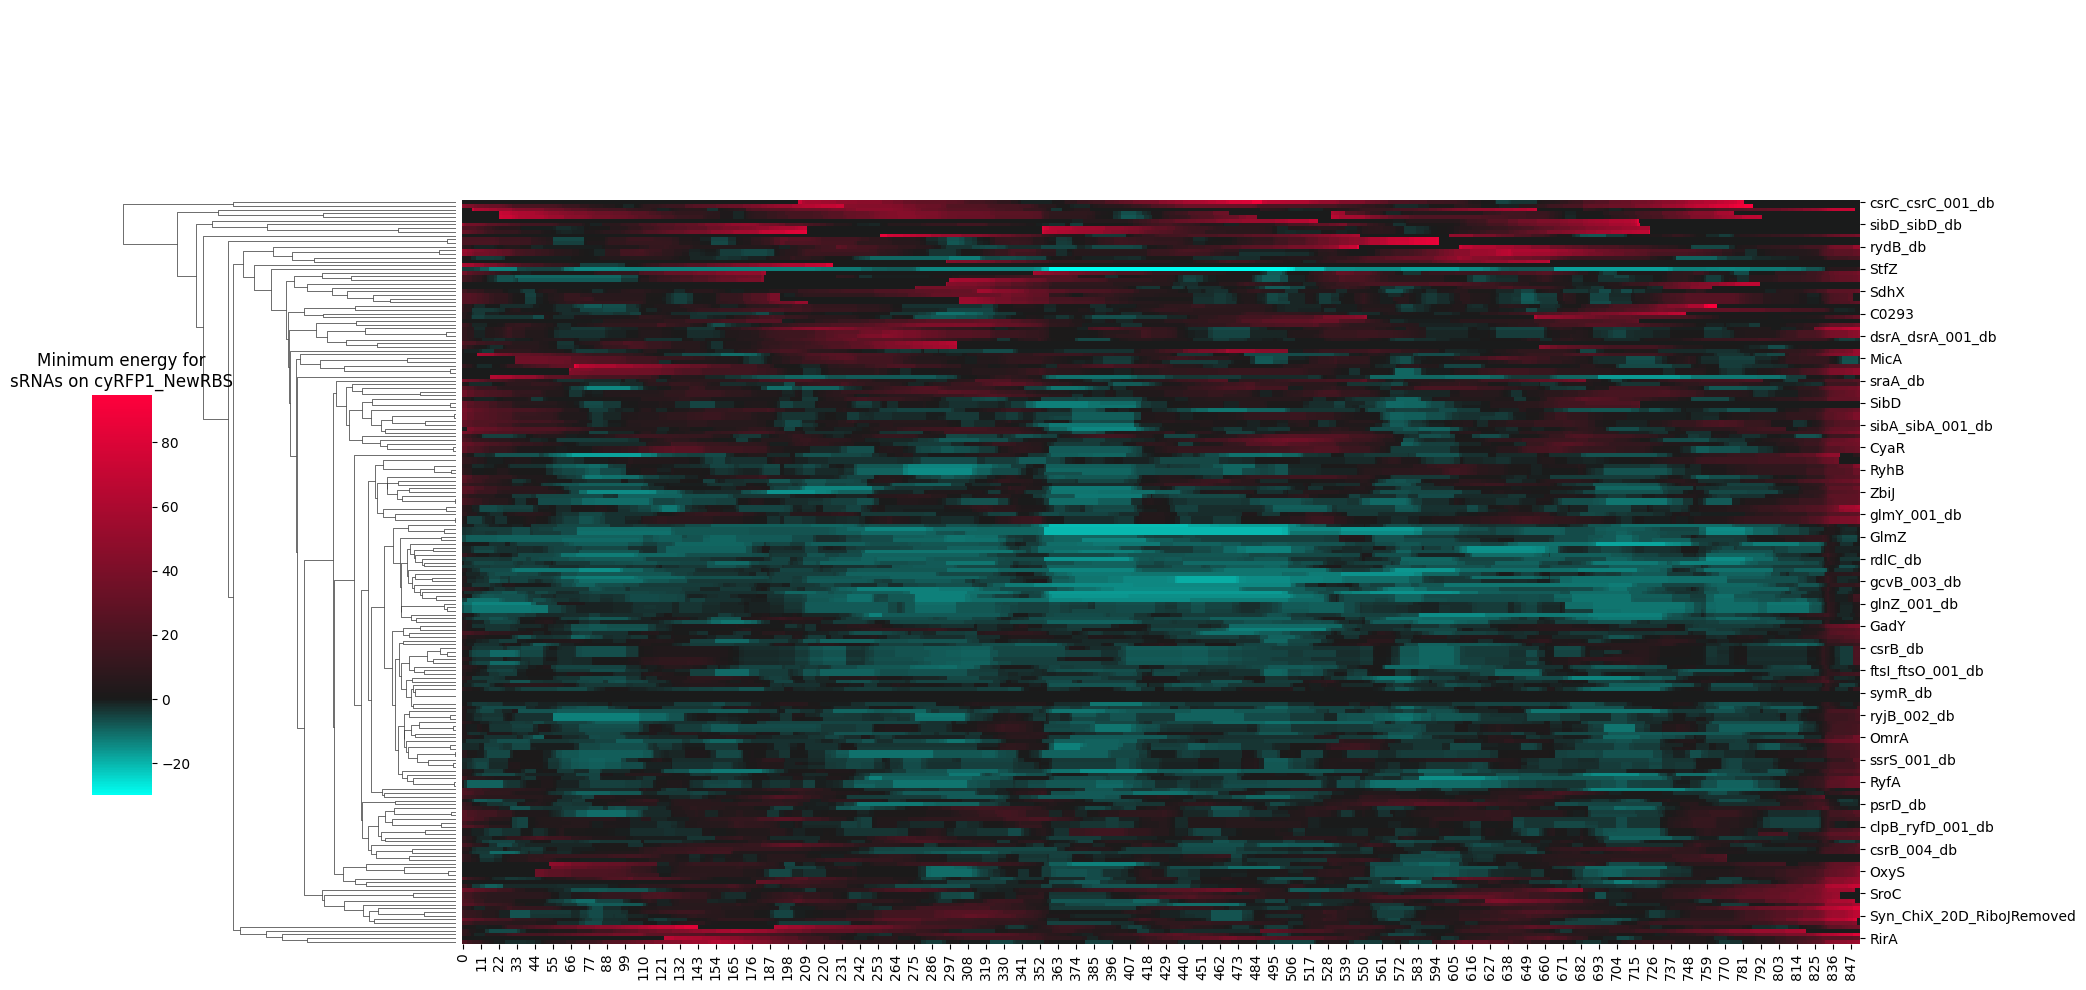

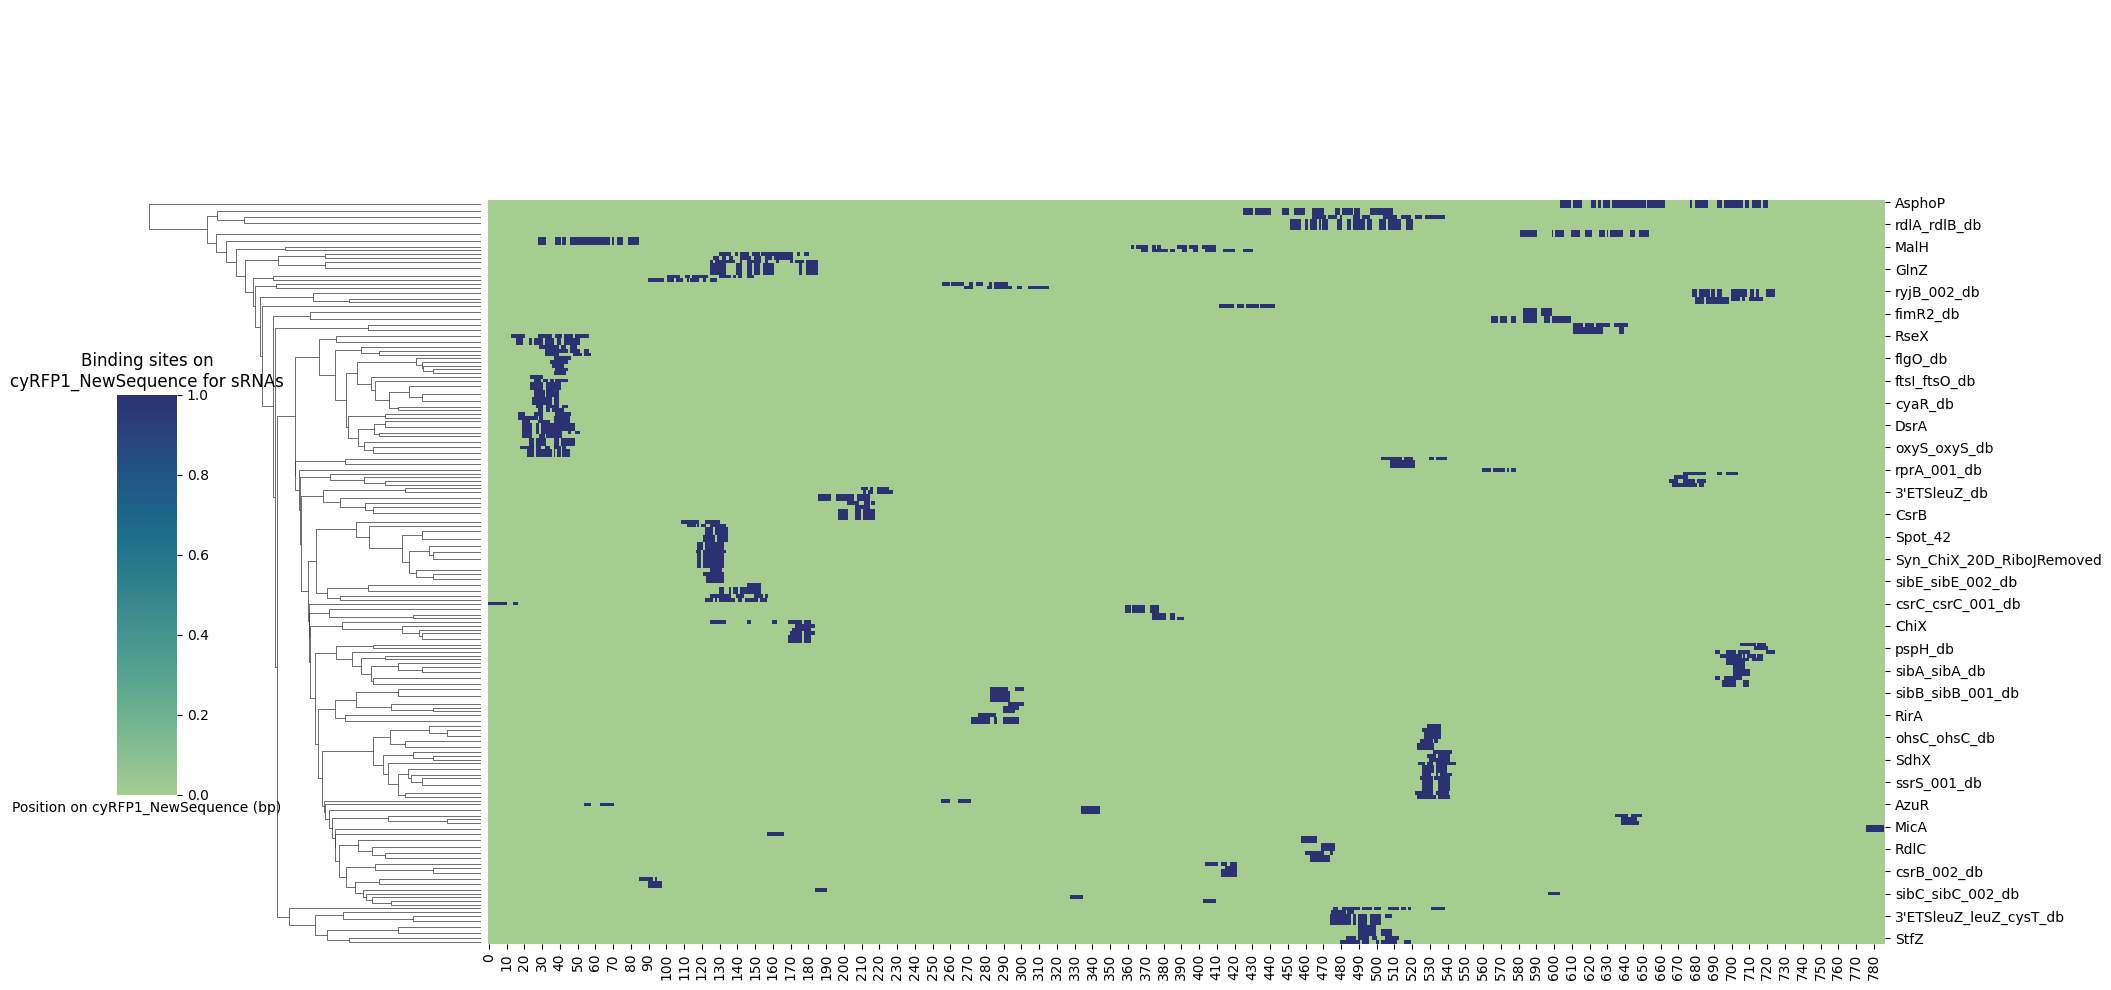

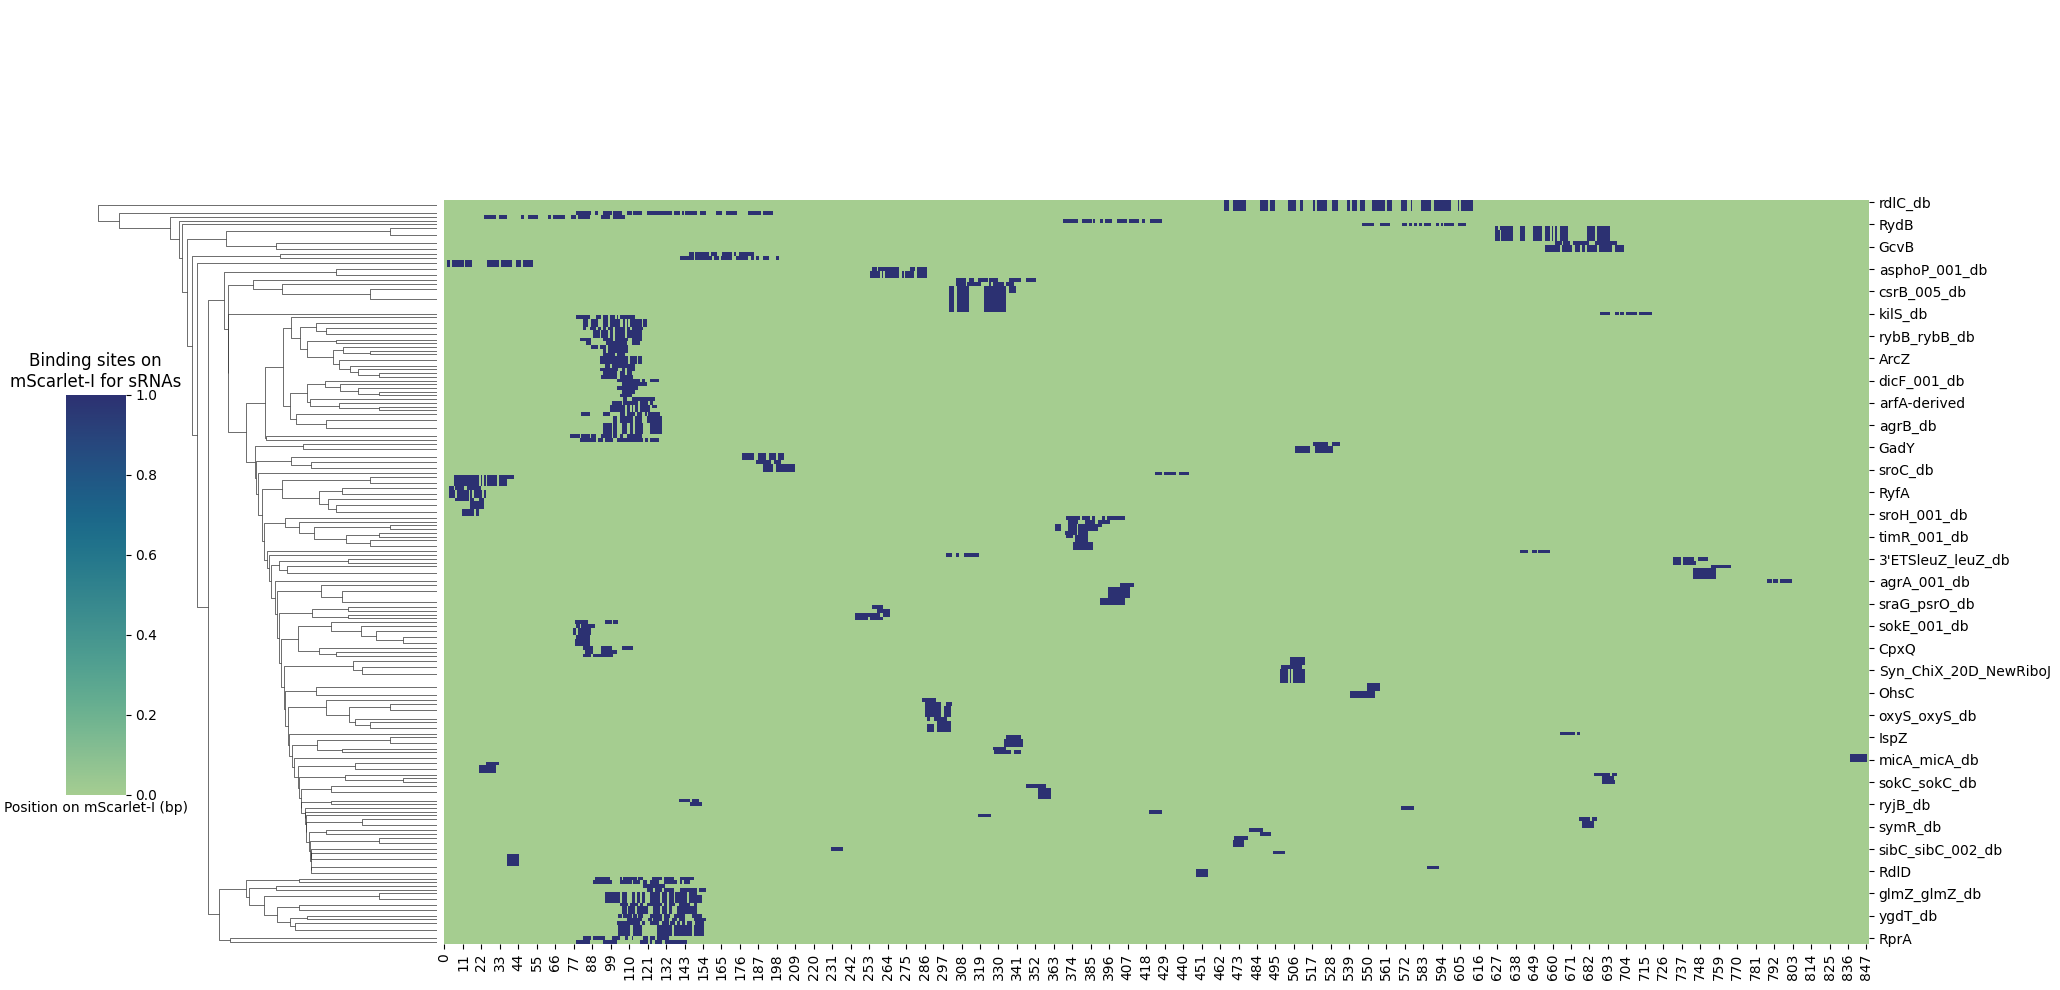

In [24]:
for i in range(len(cols_fps)):
    custom_cmap = make_diverging(-fps_mine[cols_fps[i]][srnas.keys()], center=-np.min(fps_mine[cols_fps[i]][srnas.keys()]), center_color=center_color_d, cool_color='#00fff2')
    sns.clustermap(fps_mine[cols_fps[i]][srnas.keys()].T, cmap=custom_cmap, figsize=(20, 10), col_cluster=False, cbar_pos=(0, .2, .03, .4))
    plt.title(f'Minimum energy for\nsRNAs on {cols_fps[i]}')
    # sns.clustermap(fps_spot[cols_fps[i]][srnas.keys()].T, cmap='viridis', figsize=(20, 10), col_cluster=False, cbar_pos=(0, .2, .03, .4))
    # plt.title(f'Spot probabilities for sRNAs on {cols_fps[i]}')

    sns.clustermap(binding_pos_q[cols_fps[i]].T[srnas.keys()].T, cmap='crest', figsize=(20, 10), col_cluster=False, cbar_pos=(0, .2, .03, .4))
    plt.xlabel(f'Position on {cols_fps[i]} (bp)')
    plt.title(f'Binding sites on\n{cols_fps[i]} for sRNAs')
    

### Binding positions on new and old cyRFPs

#### Differences

Text(0.5, 1.0, 'Binding sites on cyRFP1_Original for sRNAs')

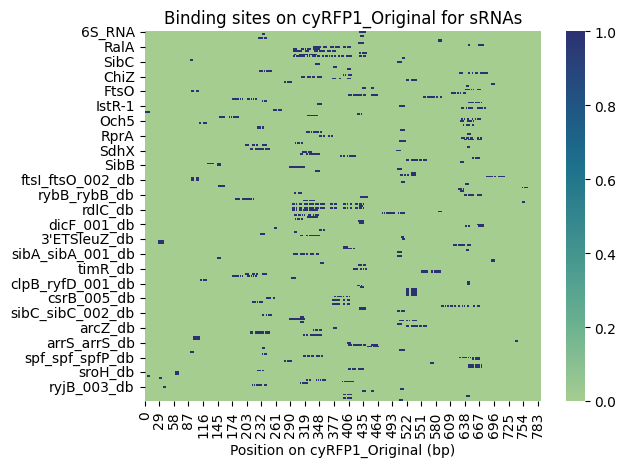

In [25]:
    # plt.figure(figsize=(20, 7*2))
    # ax = plt.subplot(2,1,1)
    # sns.heatmap(fps_spot[cols_fps[i]][srnas.keys()].T, cmap='viridis')
    # plt.title(f'Spot probabilities for sRNAs on {cols_fps[i]}')

# ax = plt.subplot(2,1,2)
i = 0
ax = sns.heatmap(binding_pos_q[cols_cyrfp[i]].T[srnas.keys()].T, cmap='crest')
plt.xlabel(f'Position on {cols_cyrfp[i]} (bp)')
plt.title(f'Binding sites on {cols_cyrfp[i]} for sRNAs')

## Visualise sRNAs and all other types of RNAs (intergenic UTR's, noncoding RNAs etc.)

### Binding positions on extra RNAs

In [26]:
binding_pos_q_extradb = {}
for fp in cols_fps:
    binding_pos_q_extradb[fp] = np.array([np.array(list(v[fp]['hybridDPfull'].split('&')[1])) == ')' if v[fp]['E'] else np.zeros(len(fps[fp]), dtype=bool) for v in sim_data_l_extradb.values()])
    binding_pos_q_extradb[fp] = pd.DataFrame(data=binding_pos_q_extradb[fp].T, columns=sim_data_l_extradb.keys()).T

# fps_extra_spots = get_spot_probabilities(os.path.join(top_dir, 'fps_extra_spots'), 'q', cols_fps, list(srnas.keys()))
# fps_extra_mine = get_spot_probabilities(os.path.join(top_dir, 'fps_extra_mine'), 'q', cols_fps, list(srnas.keys()))


# fps_extra_spots = {}
# for j in range(len(cols_fps)):
#     for i, s in enumerate(srnas.keys()):
#         r = pd.read_csv(os.path.join(top_dir, 'fps_extra_spots', f'q-t{i+1}q{j+1}.csv'), delimiter=';')
#         if s not in fps_extra_spots.get(cols_fps[j], r).columns:
#             fps_extra_spots[cols_fps[j]] = pd.concat([fps_extra_spots.get(cols_fps[j], r), r.rename(columns={'spotProb': s})[s]], axis=1)
#         else:
#             print(f'{s} would have been duplicated')
    # fps_extra_spots[cols_fps[j]] = fps_extra_spots[cols_fps[j]].T.drop_duplicates().T

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


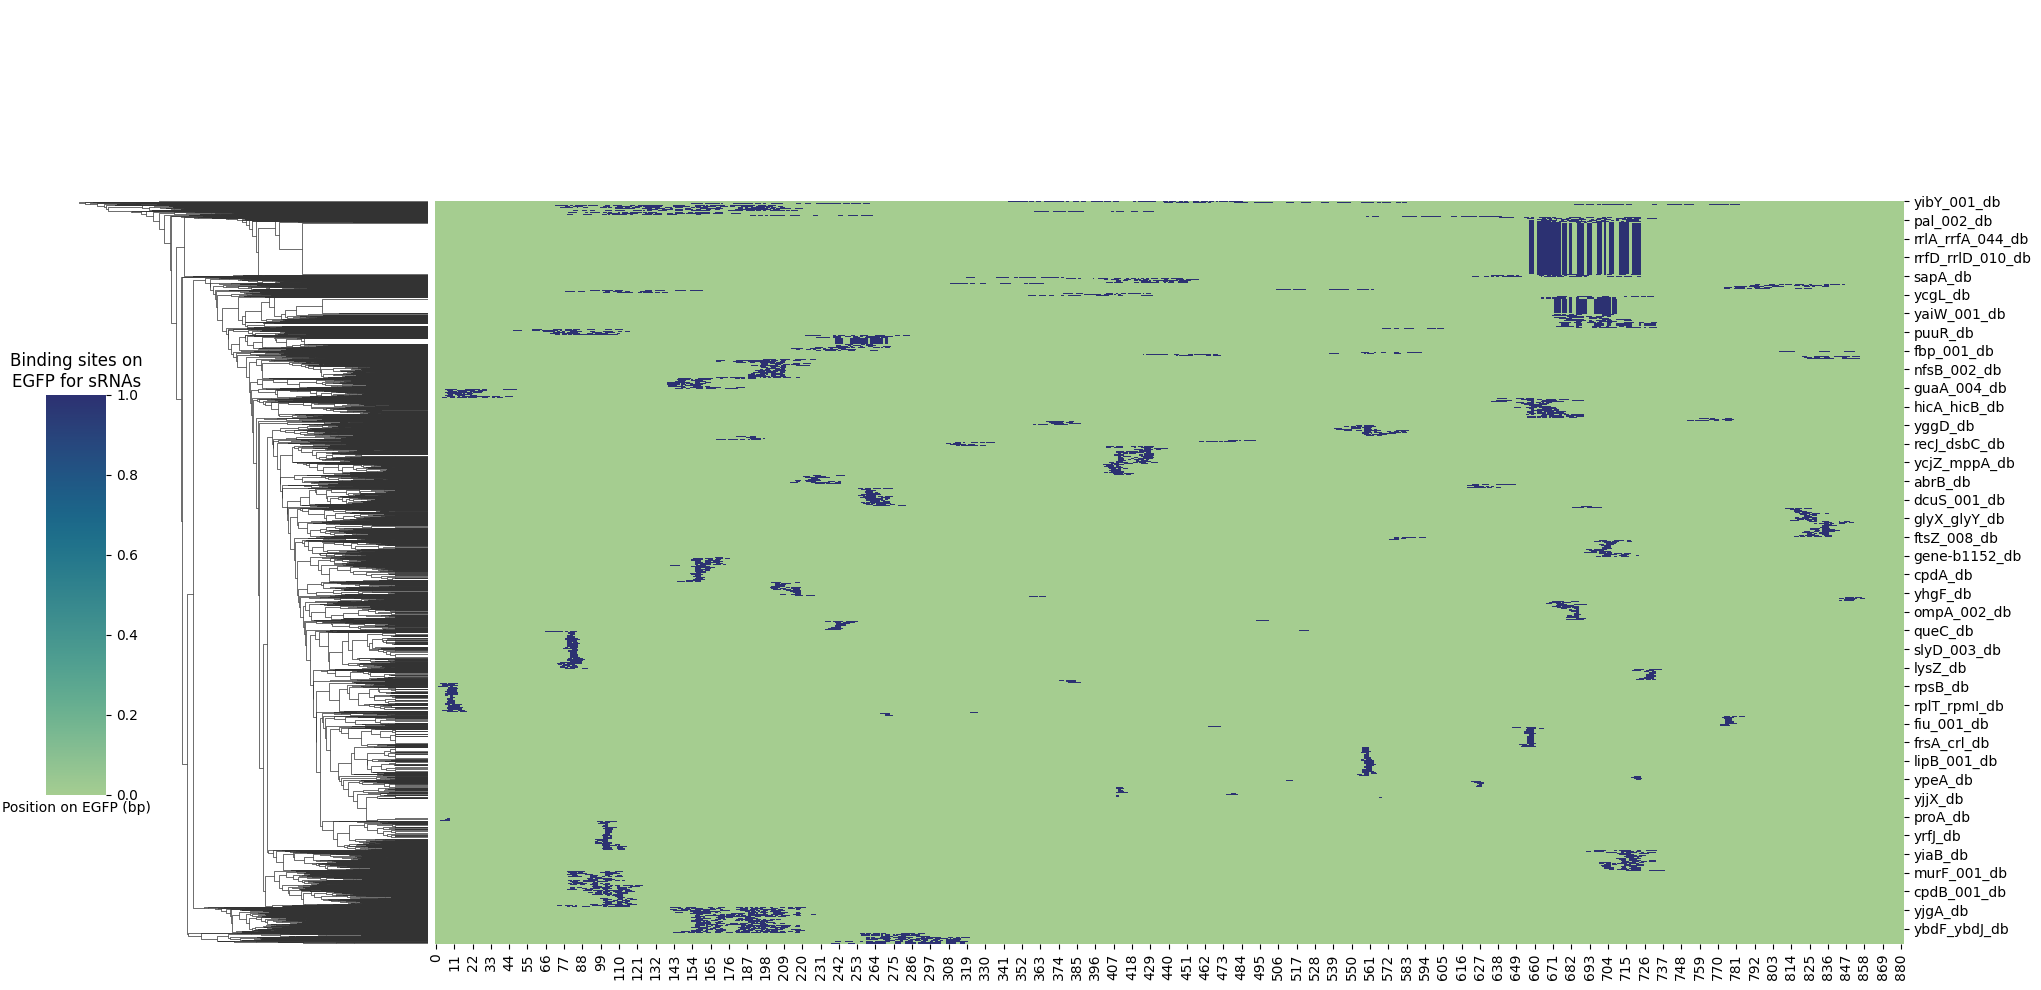

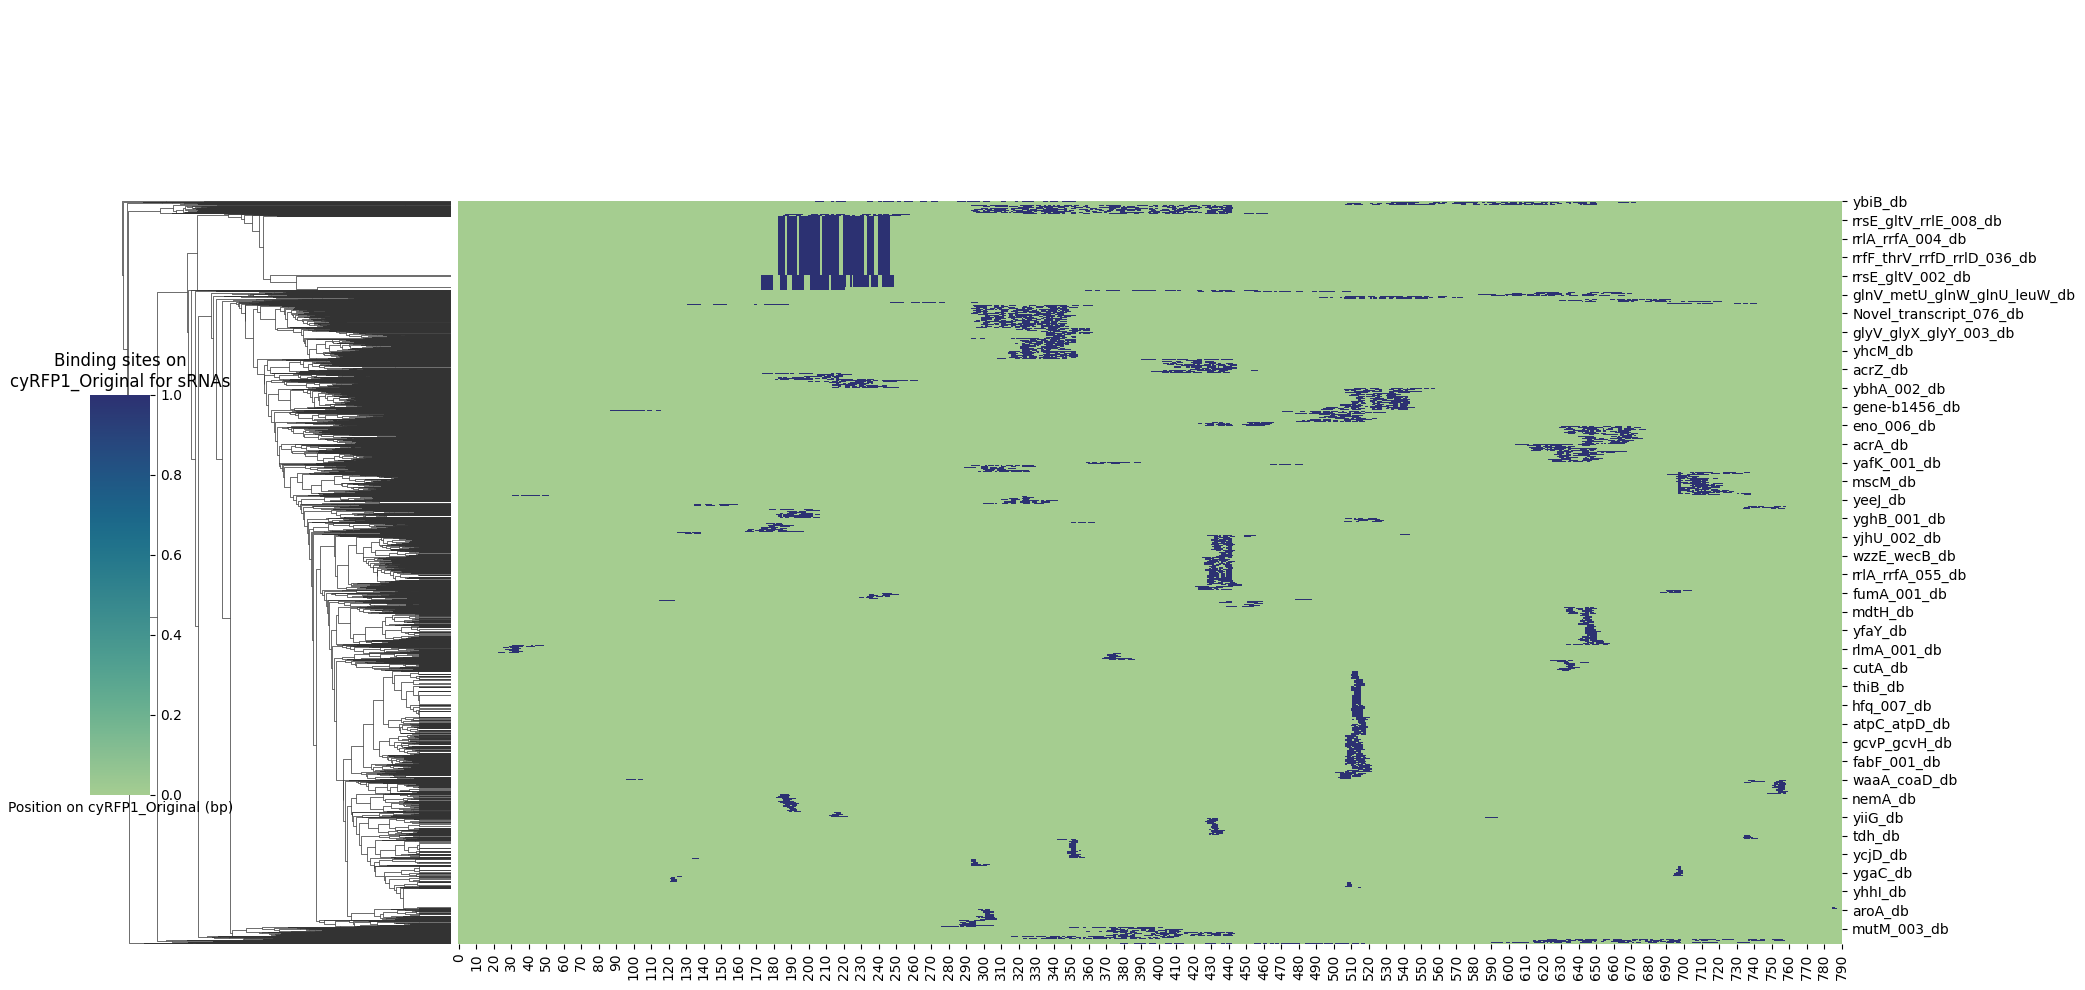

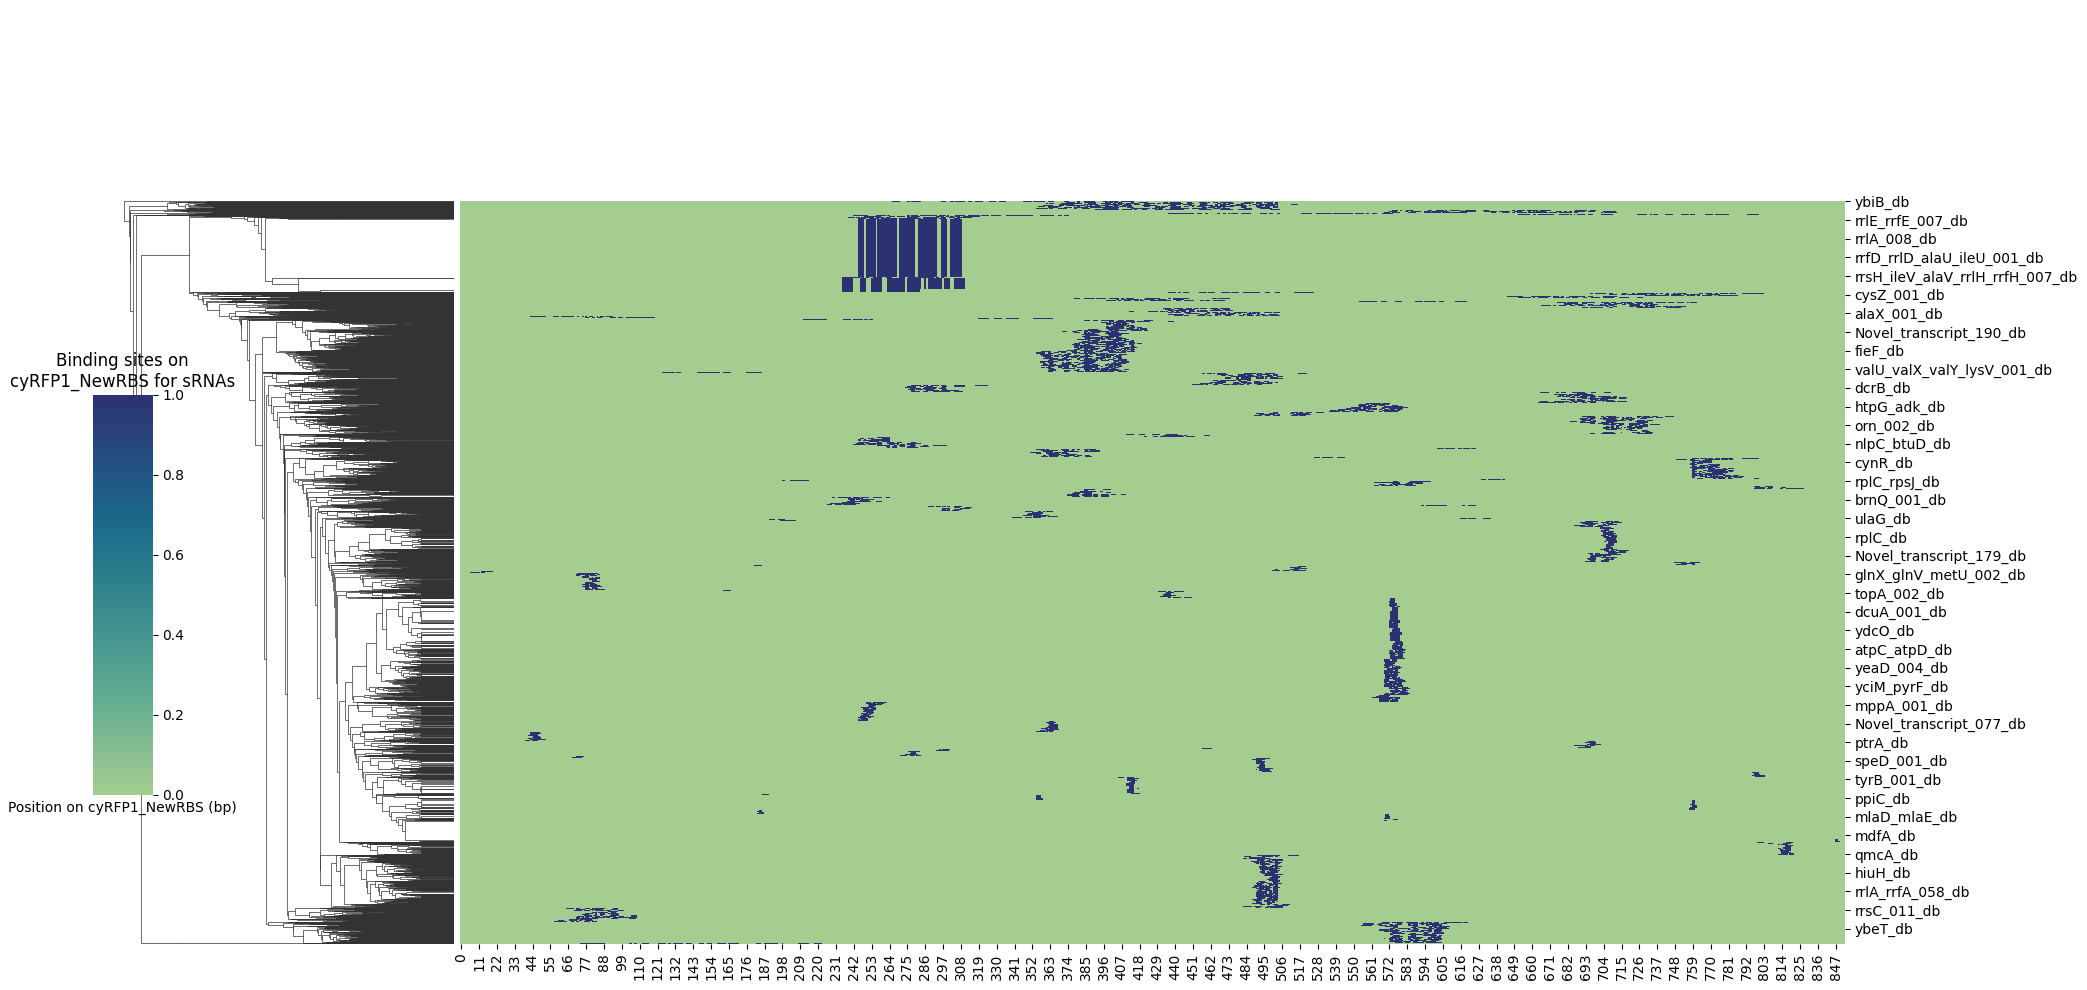

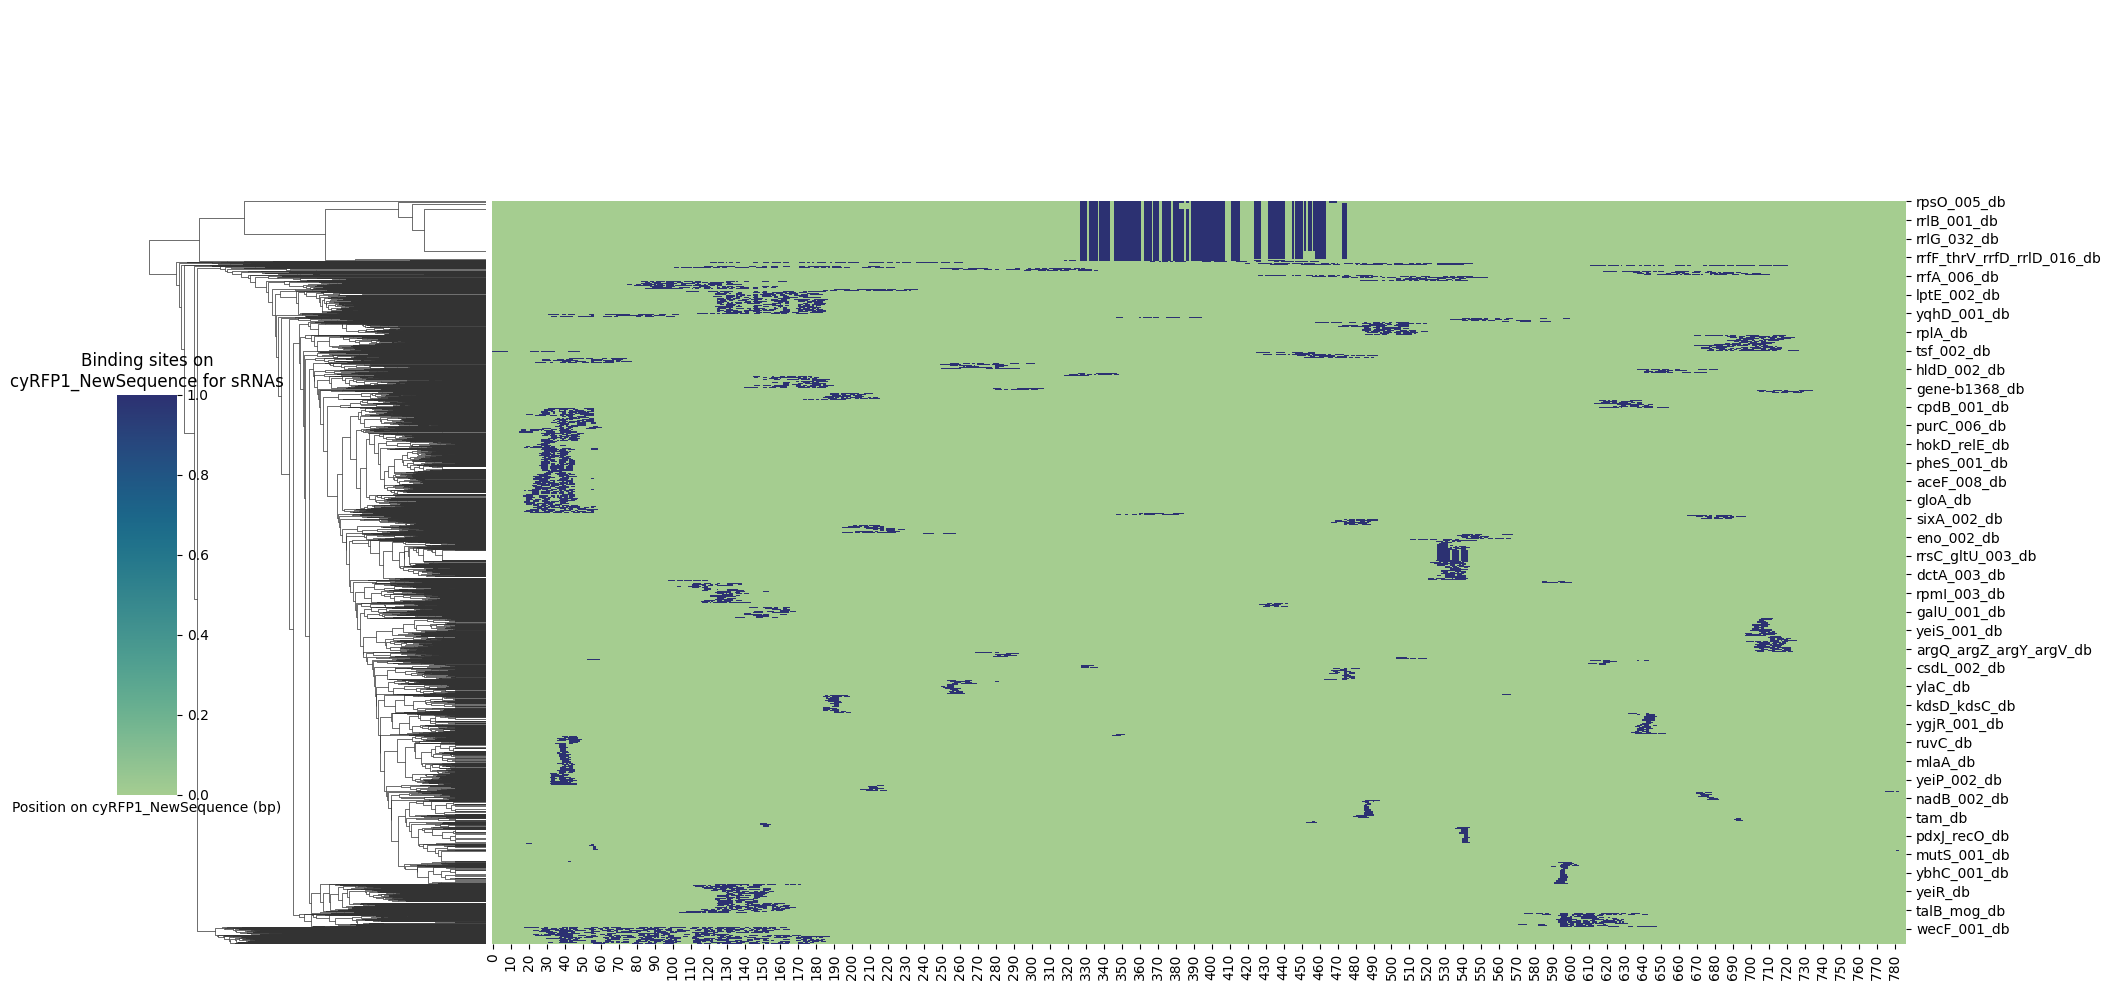

In [27]:
for i in range(len(cols_fps)):
    sns.clustermap(binding_pos_q_extradb[cols_fps[i]].T[sim_data_l_extradb.keys()].T, cmap='crest', figsize=(20, 10), col_cluster=False, cbar_pos=(0, .2, .03, .4))
    plt.xlabel(f'Position on {cols_fps[i]} (bp)')
    plt.title(f'Binding sites on\n{cols_fps[i]} for sRNAs')
    